# 📚 Stock Price & Volatility Forecasting with LSTM and Sentiment Analysis

### ✅ Asset Correlation Test using Top 100 Stocks Dataset

This script loads a CSV containing the Top 100 most traded stocks and uses the custom function `get_top_correlated_stocks` to analyze which assets have the highest historical correlation with a selected ticker. The results include metadata such as company name, sector, and correlation score, shown in a pandas DataFrame.

In [45]:
# ===============================================
# 0️⃣ DEFINE ASSETS
# ===============================================

import sys
from pathlib import Path

# Absolute path to the CSV file
csv_path = Path().resolve() / "data" / "top100_stocks.csv"

# Add src to the system path
SRC_DIR = Path().resolve() / "src"
sys.path.append(str(SRC_DIR))

from finance_utils import get_top_correlated_stocks

# Settings
TICKER = "TSLA"
top_n = 2         # number of Assets
period = "5y"     # years
historical_data = 350

n_days = 10  # print next n-days
SEQ_TO_USE = 350  # last days
HORIZON = 1       # day-by-day reconstruction
SEQ_TO_USE = 350          # last 350 days for analysis
HORIZONS_TO_PLOT = [1, 3] # days of predict
batch_size = 64

# Execute function
results = get_top_correlated_stocks(
    ticker=TICKER,
    top_n=top_n,
    period=period,
    csv_path=csv_path  # explicitly defined!
)

# Unpack results
TICKER, ADDITIONAL, ALL_TICKERS, final_df = (
    results["ticker"],
    results["additional"],
    results["all_tickers"],
    results["final_df"]
)

print("Ticker:", TICKER)
print("Additional assets:", ADDITIONAL)
print("Available tickers:", ALL_TICKERS)
print("\nTop correlated assets:")

if "Correlation" in final_df.columns:
    display(final_df[["Ticker", "Company", "Sector", "Correlation"]].round(2))
else:
    print("\n⚠️ No correlated assets found with metadata. Check CSV columns.")
    display(final_df.head())

[*********************100%***********************]  118 of 118 completed

3 Failed downloads:
['^XLE', '^CRB', '^XLK']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')



⚠️ Tickers que falharam no download e serão removidos: ['^CRB', '^XLE', '^XLK']
Ticker: TSLA
Additional assets: ['^IXIC', 'QQQ']
Available tickers: ['TSLA', '^IXIC', 'QQQ']

Top correlated assets:


,Ticker,Company,Sector,Correlation
0,^IXIC,NASDAQ Composite,Index,0.65
1,QQQ,Invesco QQQ ETF,Index,0.64


### ✅ Import libraries

Essential imports for financial analysis and stock prediction system combining quantitative data with sentiment analysis.

In [46]:
# ===============================================
# 0️⃣ IMPORTS
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import finnhub
import datetime as dt
import seaborn as sns
from prophet import Prophet
import xgboost as xgb
import os

import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import requests

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use("seaborn-v0_8")

 
### ✅ System Parameters

- `USE_SENTIMENT`: Toggle sentiment analysis (currently disabled)
- `USE_MULTIVARIATE`: Toggle multi-asset analysis (currently disabled)

In [47]:
# ===============================================
# 1️⃣ PARAMETERS
# ===============================================

USE_SENTIMENT = False  # True = include sentiment, False = ignore
USE_MULTIVARIATE = False  # True = include other assets, False = only TSLA

# Finnhub
FINNHUB_KEY = "d45q21hr01qieo4rdiugd45q21hr01qieo4rdiv0"
finnhub_client = finnhub.Client(api_key=FINNHUB_KEY)

# Yahoo Finance
ticker = results["ticker"]  
extra_tickers = results["additional"]    # auxiliary assets
data_start = "2023-01-01"
data_end = "2025-11-10"

# Prophet
HORIZON = 30  # example: next trading day + 9 business days

# XGBoost
HORIZON = 30  # number of days to predict
LAGS = [1,2,3,5,10]

# LSTM
FUTURE_DAYS = 30
SEQ_LEN = 60
TEST_RATIO = 0.2

# Graphics
historical_days = 200

## ✅ Download Historical Data

**Overview**  
Handles the download and initial processing of historical financial data for selected assets, supporting both univariate and multivariate setups.

**Functionality**  
- Downloads the main ticker's historical data (price and volume)  
- Conditionally downloads additional tickers for multivariate analysis  
- Standardizes column names and data formats  
- Prevents duplicates to avoid redundancy  

**Output Structure**  
- `dfs_auxiliary`: Dictionary containing DataFrames for each ticker  
- Columns named `{TICKER}_Close` and `{TICKER}_Volume` for clarity  
- DateTimeIndex normalized to daily frequency  

**Process Flow**  
1. Download main ticker data  
2. Standardize and filter columns  
3. Download additional tickers if multivariate mode is enabled  
4. Store all DataFrames in the auxiliary dictionary  
5. Display confirmation and summary statistics


In [48]:
# ===============================================
# 2️⃣ DOWNLOAD HISTORICAL DATA
# ===============================================
print("📥 Downloading asset data...")

dfs_auxiliary = {}

# Always download the main ticker
df_main = yf.download(ticker, start=data_start, progress=False)
df_main.columns = [c[0].title() if isinstance(df_main.columns, pd.MultiIndex) else c.title() for c in df_main.columns]
df_main = df_main[["Close","Volume"]].rename(columns={
    "Close": f"{ticker.upper()}_Close",
    "Volume": f"{ticker.upper()}_Volume"
})
df_main.index = pd.to_datetime(df_main.index).normalize()
dfs_auxiliary[ticker] = df_main

print(f"✅ {ticker.upper()} downloaded - {df_main.shape[0]} records")

# Download extras only if multivariate is active
if USE_MULTIVARIATE:
    for t in extra_tickers:
        if t == ticker:
            continue  
        df_aux = yf.download(t, start=data_start, progress=False)
        df_aux.columns = [c[0].title() if isinstance(df_aux.columns, pd.MultiIndex) else c.title() for c in df_aux.columns]
        df_aux = df_aux[["Close","Volume"]].rename(columns={
            "Close": f"{t.upper()}_Close",
            "Volume": f"{t.upper()}_Volume"
        })
        df_aux.index = pd.to_datetime(df_aux.index).normalize()
        dfs_auxiliary[t] = df_aux
        rint(f"✅ {t.upper()} downloaded - {df_aux.shape[0]} records")

print("✅ Data loaded!")

# General information about the main ticker
main_start = dfs_auxiliary[ticker].index.min()
main_end = dfs_auxiliary[ticker].index.max()
main_records = dfs_auxiliary[ticker].shape[0]

print(f"📊 Period: {main_start} to {main_end}")
print(f"📈 Main records count: {main_records}")


📥 Downloading asset data...
✅ TSLA downloaded - 718 records
✅ Data loaded!
📊 Period: 2023-01-03 00:00:00 to 2025-11-11 00:00:00
📈 Main records count: 718


## 3️⃣ Build DataFrame

**Overview**  
Consolidates all downloaded data into a unified DataFrame for analysis and modeling, handling both univariate and multivariate scenarios while ensuring temporal consistency and data quality.

**Functionality**  
- Integrates main asset data with additional features for multivariate analysis  
- Sorts data chronologically to preserve time series integrity  
- Handles missing data by forward-filling and dropping any remaining NaN values  
- Flexible design adapts automatically to univariate or multivariate configurations  

**Data Structure**  
- Univariate Mode: Only main ticker's Close and Volume data  
- Multivariate Mode: Main ticker plus additional assets as separate features  
- Columns maintain `{TICKER}_Close` and `{TICKER}_Volume` structure


In [49]:
# ===============================================
# 3️⃣ BUILD FINAL DATAFRAME
# ===============================================
df_main = dfs_auxiliary[ticker]

if USE_MULTIVARIATE:
     # join all extra assets, except the main one
    df_extra_features = pd.concat([dfs_auxiliary[t] for t in dfs_auxiliary if t != ticker], axis=1)
    df_full = pd.concat([df_main, df_extra_features], axis=1)
else:
    df_full = df_main.copy()

df_full.sort_index(inplace=True)
df_full.fillna(method="ffill", inplace=True)
df_full.dropna(inplace=True)

df_price = df_full.round(2)

print("✅ Data loaded correctly!")
print(f"📊 Period: {df_price.index.min()} to {df_price.index.max()}")
print(f"📈 Number of records: {len(df_price)}")
df_price.head()


✅ Data loaded correctly!
📊 Period: 2023-01-03 00:00:00 to 2025-11-11 00:00:00
📈 Number of records: 718


,TSLA_Close,TSLA_Volume
Date,,
2023-01-03,108.10,231402800
2023-01-04,113.64,180389000
2023-01-05,110.34,157986300
2023-01-06,113.06,220911100
2023-01-09,119.77,190284000


## ✅  Sentiment Analysis Methods
### 1️⃣ NLTK Resources Setup

Downloads required NLTK data packages for sentiment analysis and text processing.

- **VADER Lexicon**: Pre-trained sentiment analysis model
- **Punkt Tokenizer**: Text tokenization utilities

Automatically runs on import and stores result in `nltk_ready` variable for system-wide use.

In [50]:
from setup_nltk import setup_nltk

# Garantir que o NLTK esteja pronto
nltk_ready = setup_nltk()

✅ Recursos do NLTK baixados com sucesso!



### 2️⃣ Sentiment Analysis Methods

**Overview**  
Integrates multiple approaches to evaluate the tone and polarity of financial text, combining general-purpose NLP tools with domain-specific financial intelligence.

**TextBlob Analyzer**  
Computes polarity scores from –1.0 (negative) to +1.0 (positive) using the TextBlob library. Handles empty or invalid input gracefully, providing robust sentiment evaluation across diverse text sources.

**VADER Analyzer**  
Optimized for short, informal, or social media-style text. Produces a compound sentiment score capturing overall polarity. Automatically falls back to TextBlob if parsing errors occur, ensuring consistent results.

**Enhanced Financial Analyzer**  
Designed for financial contexts using custom dictionaries of positive and negative market expressions. Applies weighted scoring, normalization, and a hyperbolic tangent function to constrain scores within a stable range, providing accurate sentiment interpretation for financial news, reports, and market commentary.


In [51]:
from src.sentiment.sentiment_analysis import (
    analyze_sentiment_textblob,
    analyze_sentiment_vader,
    analyze_sentiment_enhanced,
    get_sentiment_label
)

### 3️⃣ Finnhub News Sentiment Analysis

**Overview**  
Retrieves recent company news from the Finnhub API and applies dual-layer sentiment analysis using TextBlob and VADER. Combines general linguistic tone with market-specific sentiment for nuanced interpretation.

**Functionality**  
Validates headlines and timestamps, computes polarity scores with both analyzers, combines them with equal weighting for a unified sentiment measure, and aggregates daily for time-series analysis of market sentiment.

**Implementation Details**  
Includes error handling and logging throughout the workflow. Automatically downloads the VADER lexicon if missing. Requires a valid Finnhub API key (`FINNHUB_KEY`) for API interactions.

**Dependencies**  
- `nltk` — VADER sentiment lexicon and tools  
- `textblob` — general-purpose sentiment analysis  
- `pandas` — data manipulation and aggregation  
- `requests` — API communication  

Provides a reliable framework for financial news sentiment analysis, suitable for quantitative research and market intelligence.



In [52]:
from src.sentiment.news_sentiment_finnhub import process_finnhub_news_enhanced


FINNHUB_API_KEY = FINNHUB_KEY
ticker = TICKER

df_news_sentiment = process_finnhub_news_enhanced(
    ticker=ticker,
    api_key=os.getenv("FINNHUB_KEY", FINNHUB_KEY),
    start_date=data_start,
    end_date=data_end
)

df_news_sentiment.head()


🔍 Searching Finnhub news for TSLA...
✅ 247 headlines processed → 9 days consolidated.


,sentiment_score
datetime,
2025-11-02,0.036546
2025-11-03,0.029419
2025-11-04,-0.031854
2025-11-05,0.108883
2025-11-06,0.013000


### 4️⃣ Intelligent Synthetic Sentiment Generator

**Overview**  
Generates artificial sentiment scores that reflect real market behavior by analyzing daily price movement patterns. Interprets market sentiment directly from quantitative financial signals instead of textual data.

**Functionality**  
Computes daily percentage price changes, normalizes them to a –1 to +1 range using min–max normalization, and applies a rolling average smoothing window (default 5 days) to capture broader market trends and reduce noise.

**Implementation Details**  
Includes error handling for division by zero, NaN, and infinite values. Provides flexible configuration for smoothing and normalization parameters to adapt to various financial datasets.

**Output**  
Produces a continuous, smoothed sentiment series aligned with price data. Can be used as a proxy for investor mood in the absence of textual data, supporting quantitative research, trading models, and time-series sentiment analysis.



In [53]:
from src.sentiment.synthetic_sentiment import create_intelligent_synthetic_sentiment


### 5️⃣ Sentiment Analysis Pipeline

**Overview**  
Serves as the central framework unifying real-world news sentiment and synthetic sentiment generation, delivering adaptable sentiment assessment for financial datasets. Automatically selects the most reliable source based on data availability.

**Functionality**  
When `USE_SENTIMENT` is enabled, the pipeline fetches Finnhub news sentiment if at least 20 valid entries exist; otherwise, it switches to synthetic sentiment based on price return dynamics. Aligns sentiment with price data, fills missing points using synthetic imputation, and validates input for consistency and completeness.

**Analytical Features**  
Computes statistical summaries and correlations between sentiment and price movements, providing insight into market mood and trading behavior for quantitative modeling, backtesting, and research.

**Output**  
Produces an enriched dataset with a `News_Sentiment` column, combined or synthetic sentiment values, correlation metrics, and sentiment statistics, ensuring data integrity and analytical transparency.


In [54]:
from src.sentiment.news_sentiment_pipeline import apply_sentiment_pipeline

df_full = apply_sentiment_pipeline(df_full, ticker, use_sentiment=USE_SENTIMENT)
df_full.head()


,TSLA_Close,TSLA_Volume,News_Sentiment
Date,,,
2023-01-03,108.099998,231402800,0
2023-01-04,113.639999,180389000,0
2023-01-05,110.339996,157986300,0
2023-01-06,113.059998,220911100,0
2023-01-09,119.769997,190284000,0


### 6️⃣ Sentiment Statistical Analysis and Visualization

**Overview**  
Provides a comprehensive analysis of sentiment data, combining statistical evaluation with visualizations to show how market sentiment relates to price movements.

**Functionality**  
Calculates key sentiment statistics (mean, median, standard deviation, range), analyzes distributions across seven sentiment categories, and computes correlations between sentiment and price changes to identify behavioral or market patterns.

**Visualization**  
Displays results with multi-panel charts:  
1. Time-series sentiment timeline with color-coded intensity  
2. Dual-axis chart comparing price trends and sentiment scores  
3. Correlation matrix heatmap highlighting key relationships  

**Additional Notes**  
Applies consistent thresholds for categorization, preserves target column integrity, and outputs a concise data summary for clear, data-driven insights.


✅ Price data: (718, 3)
🎯 Target column: TSLA_Close

📊 DETAILED SENTIMENT STATISTICS:
   Mean: 0.0000
   Median: 0.0000
   Standard Deviation: 0.0000
   Minimum: 0.0000
   Maximum: 0.0000

🎭 SENTIMENT DISTRIBUTION:
   STRONG POSITIVE (≥0.3)   :   0 dias (  0.0%)
   POSITIVE (0.15-0.3)      :   0 dias (  0.0%)
   LIGHT POSITIVE (0.05-0.15):   0 dias (  0.0%)
   NEUTRAL (-0.05-0.05)     : 718 dias (100.0%)
   LIGHT NEGATIVE (-0.15-0.05):   0 dias (  0.0%)
   NEGATIVE (-0.3-0.15)     :   0 dias (  0.0%)
   STRONG NEGATIVE (<-0.3)  :   0 dias (  0.0%)

🔗 SENTIMENT vs PRICE CORRELATION: nan


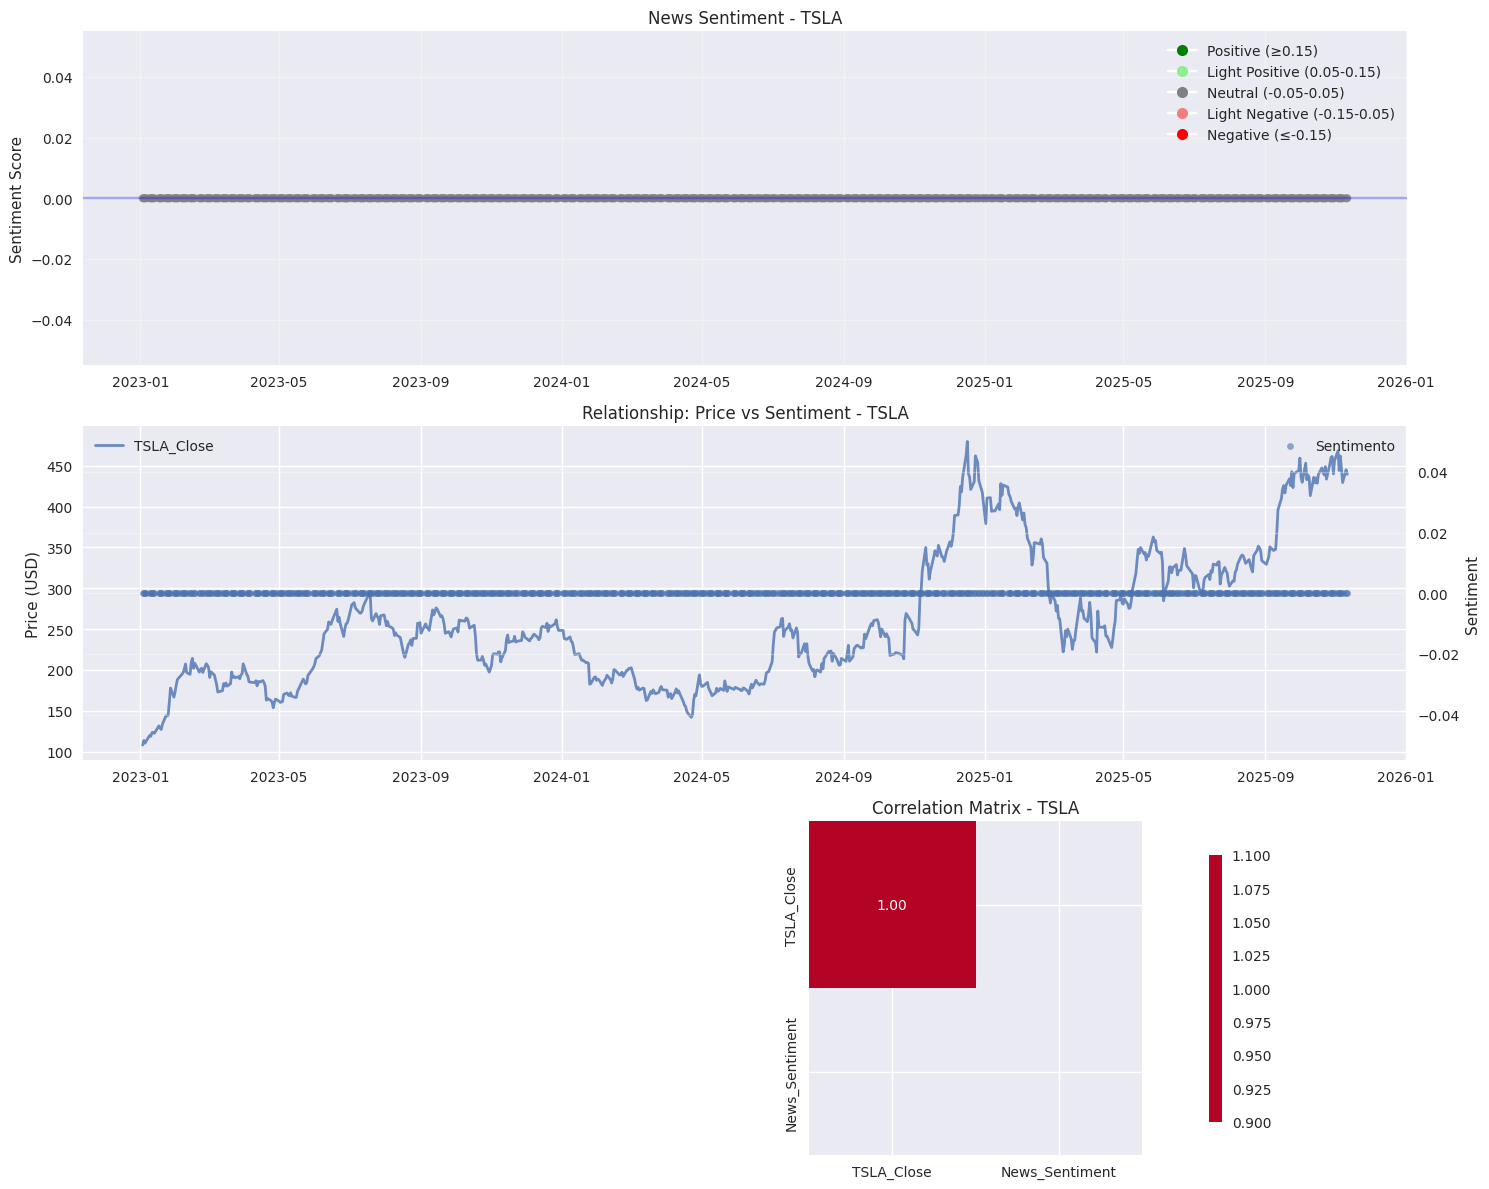


✅ SENTIMENT ANALYSIS COMPLETED!
   Final shape: (718, 3)
   Period: 2023-01-03 to 2025-11-11
   Columns: ['TSLA_Close', 'TSLA_Volume', 'News_Sentiment']


In [55]:
from src.sentiment.sentiment_analysis_stats import analyze_and_plot_sentiment

analyze_and_plot_sentiment(df_full, ticker)


## ✅ LSTM

### 1️⃣ Data Normalization and Sequence Creation for LSTM

**Overview**  
Handles data preprocessing for LSTM models, focusing on normalization and time series sequence generation. Transforms raw financial data into properly structured sequences suitable for univariate or multivariate deep learning models.

**Functionality**  
Applies Min–Max normalization for consistent feature scaling, constructs overlapping time windows based on `SEQ_LEN`, isolates the target variable for supervised learning, and splits the dataset into training and testing subsets.

**Implementation Details**  
Automatically detects the target column index, supports univariate and multivariate configurations, maintains chronological order, and handles varying data dimensions for LSTM compatibility.

**Parameters**  
- `SEQ_LEN`: Number of time steps per input sequence  
- `TEST_RATIO`: Proportion of data used for testing  
- `USE_MULTIVARIATE`: Enables multivariate sequence generation  
- `target_col`: Specifies the target column for prediction  

**Output**  
Normalized and structured sequences (`X_train`, `X_test`, `y_train`, `y_test`) ready for LSTM training and evaluation.


In [56]:
# ===============================================
# 4️⃣ NORMALIZATION
# ===============================================
target_col = f"{ticker}_Close"
target_idx = list(df_full.columns).index(target_col)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_full.values)

if not USE_MULTIVARIATE:
    scaler_uni = MinMaxScaler()
    scaler_uni.fit(df_full[[target_col]])


# ===============================================
# 5️⃣ CREATE SEQUENCES FOR LSTM
# ===============================================
def create_sequences_multivariate(data, seq_len, target_index):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, :])
        y.append(data[i, target_index]) 
    return np.array(X), np.array(y)

X, y = create_sequences_multivariate(scaled_data, SEQ_LEN, target_idx)

train_size = int((1-TEST_RATIO)*len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### 2️⃣ Multi-Feature LSTM Model Architecture

**Overview**  
Defines a robust LSTM neural network for multivariate time series forecasting, learning complex temporal dependencies across multiple input features. Integrates training optimizations, evaluation metrics, and regularization for stable and accurate financial predictions.

**Model Design**  
- Input layer: sequences of shape `(SEQ_LEN, n_features)`  
- Two stacked LSTM layers: first with 72 units (return sequences), second with 48 units  
- Dropout: 20% after each LSTM layer to prevent overfitting  
- Dense output layer: predicts single value (price or target variable)  

**Training Configuration**  
- Optimizer: Adam (learning rate = 0.001)  
- Loss: Mean Squared Error (MSE)  
- Batch size: 32, up to 60 epochs  
- Early stopping based on validation loss  
- Validation split: 10%  

**Evaluation Metrics**  
- MSE: penalizes large deviations  
- MAE: measures average error magnitude  
- MAPE: percentage-based error  
- RMSE: interpretable in original units  

**Summary**  
Captures nonlinear relationships and temporal dependencies in financial data, providing a reliable framework for short- and medium-term forecasting in data-driven finance applications.


In [ ]:
# ===============================================
# 6️⃣ MULTI-FEATURE LSTM MODEL
# ===============================================
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

lstm_model = Sequential([
    LSTM(72, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    LSTM(48),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(0.001), loss="mse", metrics=["mae", "mape", rmse])
lstm_model.summary()

es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

history = lstm_model.fit(X_train, y_train, epochs=60, batch_size=32,
                    validation_split=0.1, callbacks=[es], verbose=1)

# Final evaluation
results = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Loss (MSE): {results[0]:.4f}")
print(f"✅ Test MAE: {results[1]:.4f}")
print(f"✅ Test MAPE: {results[2]:.2f}%")
print(f"✅ Test RMSE: {results[3]:.4f}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 72)         │        21,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 48)             │        23,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,169 (176.44 KB)

 Trainable params: 45,169 (176.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


### 3️⃣ Prediction and Inverse Scaling

**Overview**  
Manages post-processing of LSTM forecasts, converting scaled predictions back to their original price scale while preserving the multi-feature structure.

**Functionality**  
Extracts non-target features from test sequences and combines them with model predictions to perform inverse scaling using the original scaler, ensuring reconstructed values align with the original feature space.

**Implementation Details**  
Maintains feature order and correct data shape, reconstructing both predicted and actual values while preserving multivariate structure.

**Process Flow**  
1. Generate scaled predictions from the trained LSTM model  
2. Extract corresponding non-target features from test sequences  
3. Merge features with predictions for inverse scaling  
4. Apply inverse transform to original scale  
5. Extract target variable for comparison  

**Output**  
- `y_test_original`: Actual target values in original scale  
- `y_pred_original`: Predicted values restored to original scale  

Completes the end-to-end workflow for accurate evaluation and visualization of model performance.



In [ ]:
# ===============================================
# 7️⃣ PREDICTION
# ===============================================
pred_scaled = lstm_model.predict(X_test)
other_features = X_test[:, -1, 1:]  # remaining columns from the sequence

inv_pred = scaler.inverse_transform(np.hstack([pred_scaled, other_features]))[:, 0]
inv_real = scaler.inverse_transform(np.hstack([y_test.reshape(-1,1), other_features]))[:, 0]

# Denormalized real and predicted values
y_test_original = inv_real        # from your prediction block
y_pred_original = inv_pred        # from your prediction block

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


### 4️⃣ Prediction Visualization

**Overview**  
Provides a professional visualization of the LSTM model’s forecasting performance, plotting actual versus predicted prices over time to assess how well the model captures market behavior.

**Functionality**  
Generates a time-series plot overlaying true and predicted prices with accurate date alignment. Applies professional styling with labeled axes, gridlines, and legend for clarity, suitable for reports or presentations.

**Implementation Details**  
Automatically aligns dates with test predictions, rotates x-axis labels for visibility, labels y-axis in USD, and includes gridlines for precise value estimation.

**Visualization Elements**  
- Blue line: Actual price values  
- Orange line: Predicted price values  
- Properly formatted date axis  
- Y-axis labeled in USD  
- Informative title including ticker and model type  

Delivers an intuitive, data-driven performance overview for quick assessment of model accuracy and forecast reliability.


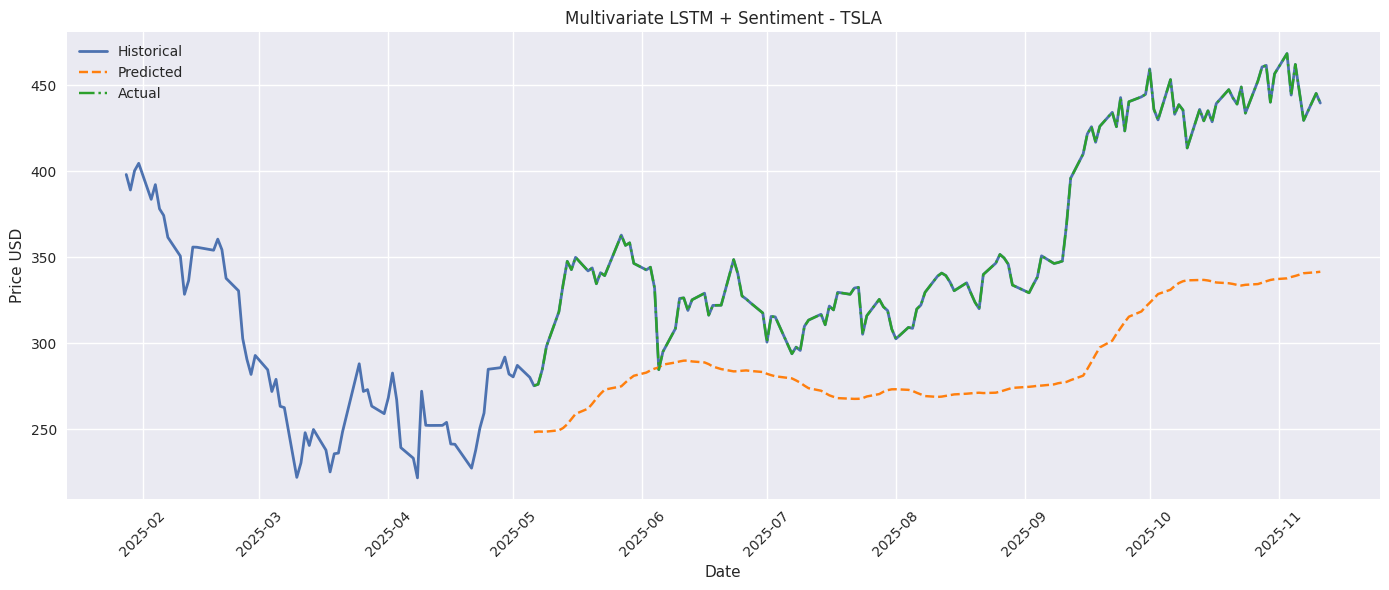

In [ ]:
# Últimos N dias históricos
hist_prices = df_full[f'{ticker}_Close'].iloc[-historical_days:]
hist_dates = df_full.index[-historical_days:]

# Datas correspondentes ao período de teste
test_dates = df_full.index[-len(y_test):]

# Plot
plt.figure(figsize=(14,6))

# Histórico
plt.plot(hist_dates, hist_prices, label="Historical", color='#4d72b0', linewidth=2)

# Previsão (test set)
plt.plot(test_dates, inv_pred, label="Predicted", color='#ff7f0e', linestyle='--')

# Real (test set)
plt.plot(test_dates, inv_real, label="Actual", color='#2ca02c', linestyle='-.')

plt.title(f"Multivariate LSTM + Sentiment - {ticker}")
plt.xlabel("Date")
plt.ylabel("Price USD")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5️⃣ Moving Averages Technical Analysis

**Overview**  
Computes and visualizes key technical indicators — Simple Moving Average (SMA) and Exponential Moving Average (EMA) — to identify market trends, support/resistance levels, and potential trading signals.

**Functionality**  
Calculates 20-day SMA and EMA, overlaying them on the asset’s price chart. Focuses on the most recent 365 days of data for clear short-term trend analysis.

**Key Concepts**  
- SMA: Equal weight to all prices, providing a stable view of trends  
- EMA: More weight to recent prices, responding faster to market changes  
- 20-day window: Commonly used for short-term momentum and trend identification  

**Technical Indicators**  
- SMA_30: Simple Moving Average (30-day)  
- EMA_30: Exponential Moving Average (30-day)  

**Use Cases**  
- Detecting and confirming trend direction  
- Identifying support and resistance zones  
- Generating buy/sell signals via moving average crossovers  

Combining SMA and EMA enables precise interpretation of price dynamics for discretionary and algorithmic trading.


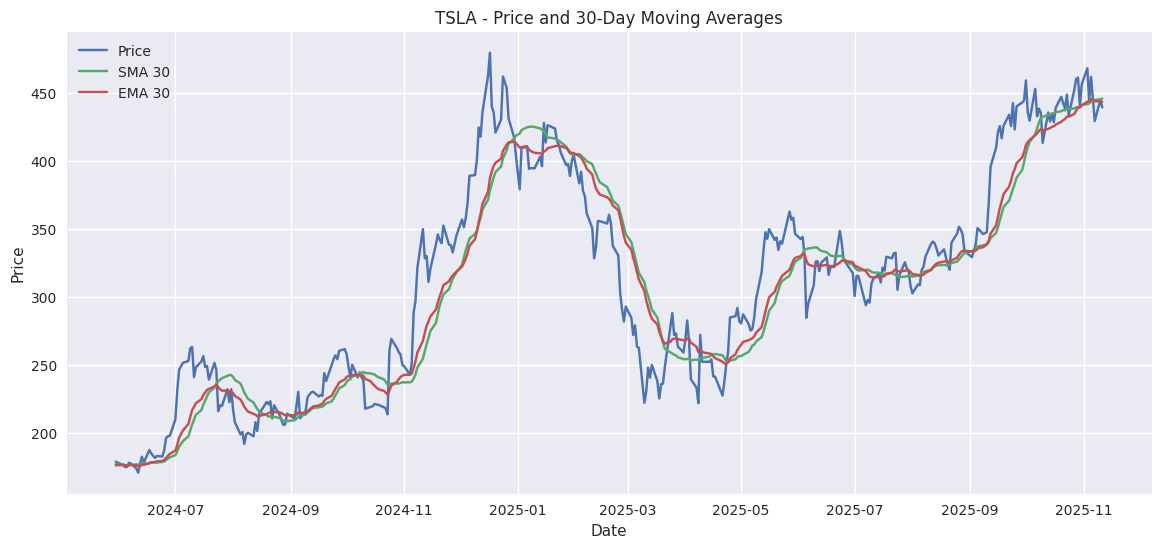

In [ ]:
# Defining the price column
price_col = f"{ticker}_Close"  # substitua pelo nome correto se diferente

# Moving averages calculation
# Simple moving average 20 days
df_full['SMA_30'] = df_full[price_col].rolling(20).mean()

# Exponential moving average 20 days
df_full['EMA_30'] = df_full[price_col].ewm(span=20, adjust=False).mean()

# Plotting
plt.figure(figsize=(14,6))
plt.plot(df_full.index[-365:], df_full[price_col][-365:], label='Price')
plt.plot(df_full.index[-365:], df_full['SMA_30'][-365:], label='SMA 30')
plt.plot(df_full.index[-365:], df_full['EMA_30'][-365:], label='EMA 30')

plt.title(f'{ticker} - Price and 30-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### 6️⃣ Feature Correlation Heatmap

**Overview**  
Generates a color-coded correlation heatmap to visualize relationships among numerical features, highlighting dependencies and potential multicollinearity issues.

**Functionality**  
Displays pairwise correlation coefficients with numeric annotations using a coolwarm color palette (blue = negative, red = positive). Each cell shows the strength and direction of the relationship between two features.

**Interpretation**  
- Red tones: Strong positive correlations (+1.0)  
- Blue tones: Strong negative correlations (–1.0)  
- Neutral colors: Weak or no correlation (~0)  

**Applications**  
Supports feature selection, data exploration, and model diagnostics by identifying redundant variables or hidden dependencies. Professional formatting with two-decimal precision provides a clear summary for statistical analysis and machine learning preparation.



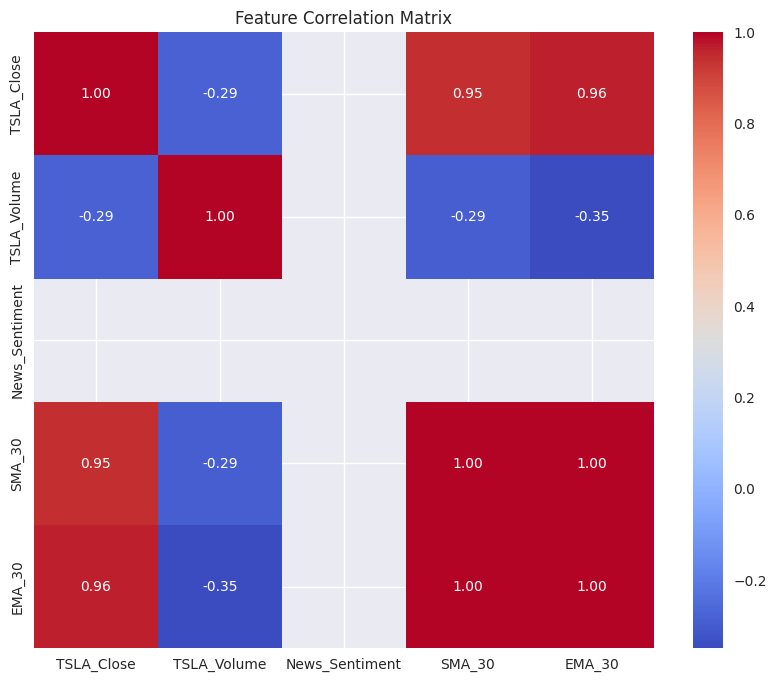

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_full.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


### 7️⃣ Future Price Prediction Horizon

**Overview**  
Extends the LSTM forecasting workflow to multi-day future predictions, providing point estimates, directional trend analysis, and performance evaluation for short- to medium-term market movements.

**Functionality**  
Recursively generates predictions from the last test sequence for a configurable `HORIZON` number of days. Each predicted value feeds into the next step. Predictions are inverse-scaled to original prices, and daily percentage changes are computed.

**Implementation Details**  
- Recursive sequence updates for multi-step forecasting  
- Proper inverse scaling to original prices  
- Calculates point-wise accuracy and directional accuracy  
- Outputs formatted for easy interpretation with a limited display of the first N forecasted days  

**Metrics Calculated**  
- MAE: Mean Absolute Error  
- RMSE: Root Mean Squared Error  
- MAPE: Mean Absolute Percentage Error  
- Directional Accuracy: proportion of correctly predicted up/down movements  

**Output**  
- Forecasted prices for the horizon  
- Daily percentage changes  
- Performance metrics on the test set  
- Visualization of the first N predicted days  

Provides a comprehensive outlook for future price movements, supporting quantitative analysis and strategic trading decisions.



In [ ]:
# ===============================================
# 🔟 FUTURE PREDICTION (HORIZON days)
# ===============================================

# -----------------------------
# 1️⃣ Predicted values in test set (apenas últimos HORIZON dias)
# -----------------------------
X_test_last = X_test[-HORIZON:]
y_test_last = y_test[-HORIZON:]

pred_scaled_test = lstm_model.predict(X_test_last)
other_features_test = X_test_last[:, -1, 1:]

# Denormalize
inv_pred_test = scaler.inverse_transform(np.hstack([pred_scaled_test, other_features_test]))[:, 0]
inv_real_test = scaler.inverse_transform(np.hstack([y_test_last.reshape(-1,1), other_features_test]))[:, 0]

# -----------------------------
# 2️⃣ Future prediction (HORIZON days)
# -----------------------------
last_sequence = X_test[-1].copy()
future_predictions_scaled = []

for _ in range(HORIZON):
    pred_scaled = lstm_model.predict(last_sequence[np.newaxis, :, :])[0,0]
    future_predictions_scaled.append(pred_scaled)
    
    # Update sequence
    new_row = np.hstack([[pred_scaled], last_sequence[-1,1:]])
    last_sequence = np.vstack([last_sequence[1:], new_row])

# Denormalize future predictions
future_prices = scaler.inverse_transform(
    np.hstack([np.array(future_predictions_scaled).reshape(-1,1),
               np.tile(last_sequence[-1,1:], (HORIZON,1))])
)[:,0]

# Future dates
future_dates = pd.date_range(df_full.index[-1] + pd.Timedelta(days=1), periods=HORIZON)
df_lstm_future = pd.DataFrame({"Predicted_Price": future_prices}, index=future_dates)
df_lstm_future["Pct_Change"] = df_lstm_future["Predicted_Price"].pct_change().fillna(0) * 100
df_lstm_future = df_lstm_future.round(2)

# -----------------------------
# 3️⃣ Detailed metrics (últimos HORIZON dias)
# -----------------------------
mae = mean_absolute_error(inv_real_test, inv_pred_test)
rmse_val = np.sqrt(mean_squared_error(inv_real_test, inv_pred_test))
mape = np.mean(np.abs((inv_real_test - inv_pred_test) / inv_real_test)) * 100

# Direction accuracy
direction_real = np.diff(inv_real_test) > 0
direction_pred = np.diff(inv_pred_test) > 0
direction_accuracy = np.mean(direction_real == direction_pred) * 100

print(f"\n📊 Performance metrics on last {HORIZON} days (LSTM):")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse_val:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"🎯 Direction Accuracy: {direction_accuracy:.2f}%")

# -----------------------------
# 4️⃣ Display only the first n_days future values
# -----------------------------
print(f"\n📊 First {n_days} Future Values Predicted by LSTM Model:")
print(df_lstm_future.head(n_days).to_string(index=True))

rows, columns = df_lstm_future.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

## ✅ Prophet Time Series Forecasting

**Overview**  
Leverages Facebook's Prophet model for robust time series forecasting, ideal for datasets with seasonal patterns and trends. Prophet decomposes time series into trend, seasonality, and holiday effects, providing reliable future predictions with performance metrics and directional accuracy.

**Functionality**  
Performs multi-period forecasting, handling daily seasonality, missing data, and outliers. Ensures proper date formatting (`ds` for dates, `y` for target) and generates future values, daily percentage changes, and trend/seasonal components.

**Model Configuration**  
- Daily seasonality enabled  
- Automatic changepoint detection for trend shifts  
- Handles missing values and outliers gracefully  
- Generates trend and seasonal components  
- Provides uncertainty intervals  

**Metrics and Evaluation**  
- MAE: Mean Absolute Error  
- RMSE: Root Mean Squared Error  
- MAPE: Mean Absolute Percentage Error  
- Directional Accuracy: correctness of up/down movement predictions  

**Output**  
- Forecasted values for the horizon  
- Daily percentage changes  
- Performance metrics on test data  
- Formatted display of first N predicted periods  

Provides an automated, interpretable, and seasonality-aware forecasting framework, ideal for financial time series with recurring patterns and trend shifts.



In [ ]:
# ===============================================
# 🔟 PROPHET
# ===============================================

price_col = f"{ticker}_Close"  # main price column

# -----------------------------
# 2️⃣ Create df_prophet from df_full
# -----------------------------
df_prophet = df_full[[price_col]].copy().reset_index()

# Ensure consistent naming
df_prophet = df_prophet.rename(columns={
    df_prophet.columns[0]: "ds",   # date column for Prophet
    df_prophet.columns[1]: "y"     # price column
})

# Ensure dates are datetime
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])

print("✅ df_prophet criado:")
print(df_prophet.head())

# -----------------------------
# 3️⃣ Train Prophet model
# -----------------------------
pro_model = Prophet(daily_seasonality=True)
pro_model.fit(df_prophet)

# -----------------------------
# 4️⃣ Create future dates and predictions
# -----------------------------
future = pro_model.make_future_dataframe(periods=HORIZON)
forecast = pro_model.predict(future)

# -----------------------------
# 5️⃣ Complete forecast
# -----------------------------
prop_df_full = forecast[["ds", "yhat"]].copy()
prop_df_full = prop_df_full.rename(columns={"yhat": "Prophet_Price"})
prop_df_full["Pct_Change"] = prop_df_full["Prophet_Price"].pct_change().fillna(0) * 100
prop_df_full["Pct_Change"] = prop_df_full["Pct_Change"].round(2)


# -----------------------------
# 6️⃣ Calculate metrics on HORIZON
# -----------------------------
real_prices = df_full[price_col].iloc[-HORIZON:].values
pred_prices = prop_df_full["Prophet_Price"].iloc[-HORIZON:].values

mae = mean_absolute_error(real_prices, pred_prices)
rmse = np.sqrt(mean_squared_error(real_prices, pred_prices))
mape = np.mean(np.abs((real_prices - pred_prices) / real_prices)) * 100

# Correct direction
direction_real = np.diff(real_prices) > 0
direction_pred = np.diff(pred_prices) > 0
direction_accuracy = np.mean(direction_real == direction_pred) * 100

print(f"\n📊 Performance metrics on last {HORIZON} days (Prophet):")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"🎯 Direction accuracy: {direction_accuracy:.2f}%")

# -----------------------------
# 6️⃣ Display first n_days
# -----------------------------
# Select only the HORIZON future days
df_prop_future = prop_df_full.tail(HORIZON).copy()  

# Display the first n_days (10, for example)
prop_df_to_show = df_prop_future.head(n_days)

print(f"\n📊 First {n_days} days of Prophet forecast:")
print(prop_df_to_show.to_string(index=False))

# Number of rows and columns
linhas, colunas = df_prop_future.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")


✅ df_prophet criado:
          ds           y
0 2023-01-03  108.099998
1 2023-01-04  113.639999
2 2023-01-05  110.339996
3 2023-01-06  113.059998
4 2023-01-09  119.769997


19:33:52 - cmdstanpy - INFO - Chain [1] start processing
19:33:52 - cmdstanpy - INFO - Chain [1] done processing



📊 Performance metrics on last 30 days (Prophet):
MAE: $55.74
RMSE: $60.64
MAPE: 12.62%
🎯 Direction accuracy: 48.28%

📊 First 10 days of Prophet forecast:
        ds  Prophet_Price  Pct_Change
2025-11-12     464.078761        0.51
2025-11-13     464.024128       -0.01
2025-11-14     467.574685        0.77
2025-11-15     470.813950        0.69
2025-11-16     472.587653        0.38
2025-11-17     473.660904        0.23
2025-11-18     474.979218        0.28
2025-11-19     476.866125        0.40
2025-11-20     476.526650       -0.07
2025-11-21     479.985401        0.73
The DataFrame has 30 rows and 2 columns.


## ✅ XGBoost Time Series Forecasting

**Overview**  
Applies XGBoost, a gradient boosting regression model, to time series forecasting using lagged features to capture temporal dependencies. Offers predictive power with interpretable, feature-driven analysis.

**Functionality**  
Generates lag features from historical prices (1, 2, 3, 5, 10-day lags) to encode temporal patterns. Performs recursive multi-step forecasting, feeding each predicted value back into the input. Calculates daily percentage changes and evaluates point forecasts and directional accuracy.

**Feature Engineering**  
- Constructs lagged price features for momentum and temporal dependencies  
- Handles NaN values from shifting operations  
- Maintains consistent feature window for sequential predictions  

**Model Configuration**  
- Objective: `reg:squarederror`  
- Number of estimators: 100  
- Standard train-test split (80–20%)  

**Output**  
- Future price predictions for configurable horizon  
- Daily percentage changes  
- Performance metrics: MAE, RMSE, MAPE, directional accuracy  
- Formatted display of first N forecasted days  

Provides a feature-driven, high-performance forecasting framework suitable for financial time series, enabling precise predictions and insight into trend dynamics.


In [ ]:
# ===============================================
# 🔹 XGBoost Forecasting - Últimos 30 dias
# ===============================================

price_col = f"{ticker}_Close"
TEST_RATIO = 0.2    # test proportion

# -----------------------------
# 2️⃣ Create lag features for XGBoost
# -----------------------------
def create_lags(df, col, lags):
    df_lags = pd.DataFrame()
    for lag in lags:
        df_lags[f"{col}_lag{lag}"] = df[col].shift(lag)
    df_lags["y"] = df[col]
    df_lags = df_lags.dropna()
    return df_lags

xgb_df = create_lags(df_full, price_col, LAGS)

# Features e target
X = xgb_df.drop("y", axis=1).values
y = xgb_df["y"].values

# Train-test split
split = int(len(X)*(1-TEST_RATIO))
X_train_xgb, X_test_xgb = X[:split], X[split:]
y_train_xgb, y_test_xgb = y[:split], y[split:]

# -----------------------------
# 3️⃣ Train XGBoost model
# -----------------------------
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

# -----------------------------
# 1️⃣ Test prediction - últimos HORIZON dias
# -----------------------------
X_test_last = X_test[-HORIZON:]
y_test_last = y_test[-HORIZON:]

xgb_pred_test = xgb_model.predict(X_test_xgb)

mae = mean_absolute_error(y_test_xgb, xgb_pred_test)
rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred_test))
mape = np.mean(np.abs((y_test_xgb - xgb_pred_test)/y_test_xgb))*100

direction_real = np.diff(y_test_xgb) > 0
direction_pred = np.diff(xgb_pred_test) > 0
direction_accuracy = np.mean(direction_real == direction_pred) * 100

print(f"\n📊 Performance metrics on last {HORIZON} days (XGBoost):")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse_val:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"🎯 Direction Accuracy: {direction_accuracy:.2f}%")

# -----------------------------
# 2️⃣ Complete future prediction (HORIZON dias)
# -----------------------------
last_values = df_full[price_col].values[-max(LAGS):].tolist()
future_predictions = []

for i in range(HORIZON):
    features = np.array([last_values[-lag] for lag in LAGS]).reshape(1, -1)
    pred = xgb_model.predict(features)[0]
    future_predictions.append(pred)
    last_values.append(pred)

future_dates = pd.date_range(df_full.index[-1] + pd.Timedelta(days=1), periods=HORIZON)

xgb_pct_change = [((future_predictions[i] - (last_values[-HORIZON-1+i] if i==0 else future_predictions[i-1]))
                   / (last_values[-HORIZON-1+i] if i==0 else future_predictions[i-1])) * 100
                  for i in range(HORIZON)]

df_xgb_future = pd.DataFrame({
    "Date": future_dates,
    "XGB_Price": np.round(future_predictions, 2),
    "Pct_Change": np.round(xgb_pct_change, 2)
})

# -----------------------------
# 3️⃣ Display only the first n_days
# -----------------------------
df_xgb_forecast = df_xgb_future.head(n_days)
print(f"\n📊 First {n_days} days of XGBoost forecast")
print(df_xgb_forecast.to_string(index=False))

rows, columns = df_xgb_future.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")



📊 Performance metrics on last 30 days (XGBoost):
MAE: $11.63
RMSE: $108.23
MAPE: 3.30%
🎯 Direction Accuracy: 50.35%

📊 First 10 days of XGBoost forecast
      Date  XGB_Price  Pct_Change
2025-11-12 449.640015        2.28
2025-11-13 437.630005       -2.67
2025-11-14 437.489990       -0.03
2025-11-15 437.630005        0.03
2025-11-16 437.630005        0.00
2025-11-17 437.630005        0.00
2025-11-18 437.630005        0.00
2025-11-19 437.630005        0.00
2025-11-20 437.630005        0.00
2025-11-21 437.630005        0.00
The DataFrame has 30 rows and 3 columns.


## ✅ Ensemble Forecast Simplified – First N Days

**Overview**  
Implements a simple averaging ensemble of LSTM, Prophet, and XGBoost to enhance prediction accuracy and reduce individual model biases. Provides a robust short-term forecast with clear performance metrics.

**Functionality**  
Computes the equal-weighted average of predictions from the three models, compares against actual prices, calculates daily percentage changes, and evaluates point-wise and directional forecast accuracy.

**Implementation Details**  
- Equal weighting for LSTM, Prophet, and XGBoost  
- Focus on the first N days (default: 10)  
- Rounded values for clarity  
- Evaluates both point-wise errors and trend direction  

**Ensemble Approach**  
- Simple averaging strategy, no complex weighting  
- Leverages strengths of diverse model architectures  
- Mitigates individual model weaknesses and biases  

**Output Metrics**  
- MAE, RMSE, MAPE on ensemble predictions  
- Directional accuracy for trend prediction  
- Daily forecasted prices with percentage changes  
- Formatted table display for quick interpretation  

Provides a practical, interpretable, and robust forecast leveraging complementary strengths of multiple predictive models.



In [ ]:
# ===============================================
# 🔹 Ensemble Forecast - last 30 days
# ===============================================

# Select the last HORIZON days of predictions for each model
lstm_preds = df_lstm_future["Predicted_Price"].iloc[:HORIZON].values
prophet_preds = df_prop_future["Prophet_Price"].iloc[:HORIZON].values
xgb_preds = df_xgb_future["XGB_Price"].iloc[:HORIZON].values

# Simple ensemble: average of predictions
ensemble_preds = (lstm_preds + prophet_preds + xgb_preds) / 3

# -----------------------------
# Detailed ensemble metrics
# ----------------------------
real_prices = df_full[f"{ticker}_Close"].iloc[-HORIZON:].values

mae = mean_absolute_error(real_prices, ensemble_preds)
rmse_val = np.sqrt(mean_squared_error(real_prices, ensemble_preds))
mape = np.mean(np.abs((real_prices - ensemble_preds) / real_prices)) * 100
direction_real = np.diff(real_prices) > 0
direction_pred = np.diff(ensemble_preds) > 0
direction_accuracy = np.mean(direction_real == direction_pred) * 100

# Print metrics
print(f"\n📊 Performance metrics on last {HORIZON} days (Ensemble):")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse_val:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"🎯 Direction Accuracy: {direction_accuracy:.2f}%")

# -----------------------------
# Create ensemble DataFrame
# -----------------------------
ensemble_df = pd.DataFrame({
    "Date": df_lstm_future.index[:HORIZON].date,
    "Ensemble": np.round(ensemble_preds, 2) 
})

# Calculate daily percentage change
ensemble_df["Pct_Change"] = np.round(ensemble_df["Ensemble"].pct_change().fillna(0) * 100, 2)

# Display only the first n_days
print(f"\n📊 Ensemble Forecast - First {n_days} days of last {HORIZON} days")
print(ensemble_df.head(n_days).to_string(index=False))



📊 Performance metrics on last 30 days (Ensemble):
MAE: $36.73
RMSE: $39.40
MAPE: 8.22%
🎯 Direction Accuracy: 48.28%

📊 Ensemble Forecast - First 10 days of last 30 days
      Date  Ensemble  Pct_Change
2025-11-12    418.44        0.00
2025-11-13    413.94       -1.08
2025-11-14    414.18        0.06
2025-11-15    414.09       -0.02
2025-11-16    413.23       -0.21
2025-11-17    411.97       -0.30
2025-11-18    410.68       -0.31
2025-11-19    409.53       -0.28
2025-11-20    407.61       -0.47
2025-11-21    406.96       -0.16


## ✅ Model Comparison: LSTM vs Prophet vs XGBoost vs Ensemble

**Overview**  
Compares LSTM, Prophet, XGBoost, and their ensemble, showing predictions, percentage changes, and key metrics for informed model selection.

**Key Features**  
Aligns all model outputs side by side, calculates a simple average ensemble, and evaluates each method with performance metrics and directional accuracy.

**Important Details**  
Computes percentage changes for all predictions and evaluates performance on recent actual data. Both price values and relative changes are included.

**Comparison Metrics**  
Evaluates models using MAE, RMSE, MAPE, and directional accuracy to assess both prediction accuracy and trend correctness.

**Model Evaluation**  
LSTM captures temporal dependencies, Prophet handles trends and seasonality, XGBoost leverages feature engineering, and the ensemble combines their strengths for improved forecasts.



In [ ]:
# ===============================================
# 🔹 Comparison of 3 Models + Ensemble - last 30 days
# ===============================================

# -----------------------------
# Prepare future data (últimos HORIZON dias)
# -----------------------------
lstm_df = df_lstm_future.iloc[:HORIZON].rename(columns={"Predicted_Price": "LSTM_Price", "Pct_Change": "LSTM_Pct_Change"})
prophet_df = df_prop_future.iloc[:HORIZON].rename(columns={"Prophet_Price": "Prophet_Price", "Pct_Change": "Prophet_Pct_Change"})
xgb_df = df_xgb_future.iloc[:HORIZON].rename(columns={"XGB_Price": "XGB_Price", "Pct_Change": "XGB_Pct_Change"})

# Ensemble: média simples dos 3 modelos
ensemble_prices = (lstm_df["LSTM_Price"].values + 
                   prophet_df["Prophet_Price"].values + 
                   xgb_df["XGB_Price"].values) / 3
ensemble_pct = np.round(np.diff(np.insert(ensemble_prices, 0, ensemble_prices[0])) / ensemble_prices * 100, 2)

ensemble_df = pd.DataFrame({
    "Ensemble_Price": np.round(ensemble_prices, 2),
    "Ensemble_Pct_Change": ensemble_pct
}, index=lstm_df.index)

# -----------------------------
# Combine into single DataFrame for display
# -----------------------------
comparison_df = pd.DataFrame({
    "Date": lstm_df.index.date,
    "LSTM_Price": lstm_df["LSTM_Price"].values,
    "LSTM_Pct_Change": lstm_df["LSTM_Pct_Change"].values,
    "Prophet_Price": prophet_df["Prophet_Price"].values,
    "Prophet_Pct_Change": prophet_df["Prophet_Pct_Change"].values,
    "XGB_Price": xgb_df["XGB_Price"].values,
    "XGB_Pct_Change": xgb_df["XGB_Pct_Change"].values,
    "Ensemble_Price": ensemble_df["Ensemble_Price"].values,
    "Ensemble_Pct_Change": ensemble_df["Ensemble_Pct_Change"].values
})

# -----------------------------
# Show comparison (first n_days)
# -----------------------------
print(f"📊 Comparison of predictions from 3 models + Ensemble (first {n_days} of last {HORIZON} days):")
print(comparison_df.head(n_days).to_string(index=False))

# -----------------------------
# Summary metrics for each model (last HORIZON days)
# -----------------------------
real_prices = df_full[f"{ticker}_Close"].iloc[-HORIZON:].values

def calculate_metrics(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    mape = np.mean(np.abs((real - pred) / real)) * 100
    direction_real = np.diff(real) > 0
    direction_pred = np.diff(pred) > 0
    direction_accuracy = np.mean(direction_real == direction_pred) * 100
    return mae, rmse, mape, direction_accuracy

metrics = {}
metrics['LSTM'] = calculate_metrics(real_prices, lstm_df["LSTM_Price"].values)
metrics['Prophet'] = calculate_metrics(real_prices, prophet_df["Prophet_Price"].values)
metrics['XGBoost'] = calculate_metrics(real_prices, xgb_df["XGB_Price"].values)
metrics['Ensemble'] = calculate_metrics(real_prices, ensemble_df["Ensemble_Price"].values)

# -----------------------------
# Display metrics
# -----------------------------
print(f"\n📊 Performance metrics (last {HORIZON} days):")
for model_name, vals in metrics.items():
    mae, rmse, mape, direction_accuracy = vals
    print(f"{model_name}: MAE=${mae:.2f}, RMSE=${rmse:.2f}, MAPE={mape:.2f}%, 🎯 Direction={direction_accuracy:.2f}%")


📊 Comparison of predictions from 3 models + Ensemble (first 10 of last 30 days):
      Date  LSTM_Price  LSTM_Pct_Change  Prophet_Price  Prophet_Pct_Change  XGB_Price  XGB_Pct_Change  Ensemble_Price  Ensemble_Pct_Change
2025-11-12      341.60             0.00     464.078761                0.51 449.640015            2.28          418.44                 0.00
2025-11-13      340.18            -0.42     464.024128               -0.01 437.630005           -2.67          413.94                -1.09
2025-11-14      337.49            -0.79     467.574685                0.77 437.489990           -0.03          414.18                 0.06
2025-11-15      333.84            -1.08     470.813950                0.69 437.630005            0.03          414.09                -0.02
2025-11-16      329.48            -1.31     472.587653                0.38 437.630005            0.00          413.23                -0.21
2025-11-17      324.62            -1.47     473.660904                0.23 437.630005

## ✅ Model Comparison Visualization

**Overview**  
Generates a clear visualization comparing historical prices with future predictions from all models, providing an intuitive view of performance and trends.

**Key Features**  
Shows historical price trends alongside model predictions with consistent colors and professional formatting, including grids, legends, and customizable periods.

**Important Details**  
Distinct markers differentiate models (circles, crosses, squares, triangles). Dashed lines indicate future predictions, and dates are automatically formatted and rotated for readability.

**Visual Elements**  
- Historical data: Solid blue line  
- LSTM predictions: Purple circles, dashed line  
- Prophet predictions: Orange crosses, dashed line  
- XGBoost predictions: Green squares, dashed line  
- Ensemble predictions: Red triangles, dashed line  

**Customization**  
`historical_days` controls displayed historical data. Colors, markers, and line styles can be modified via `colors` array and model-specific settings.


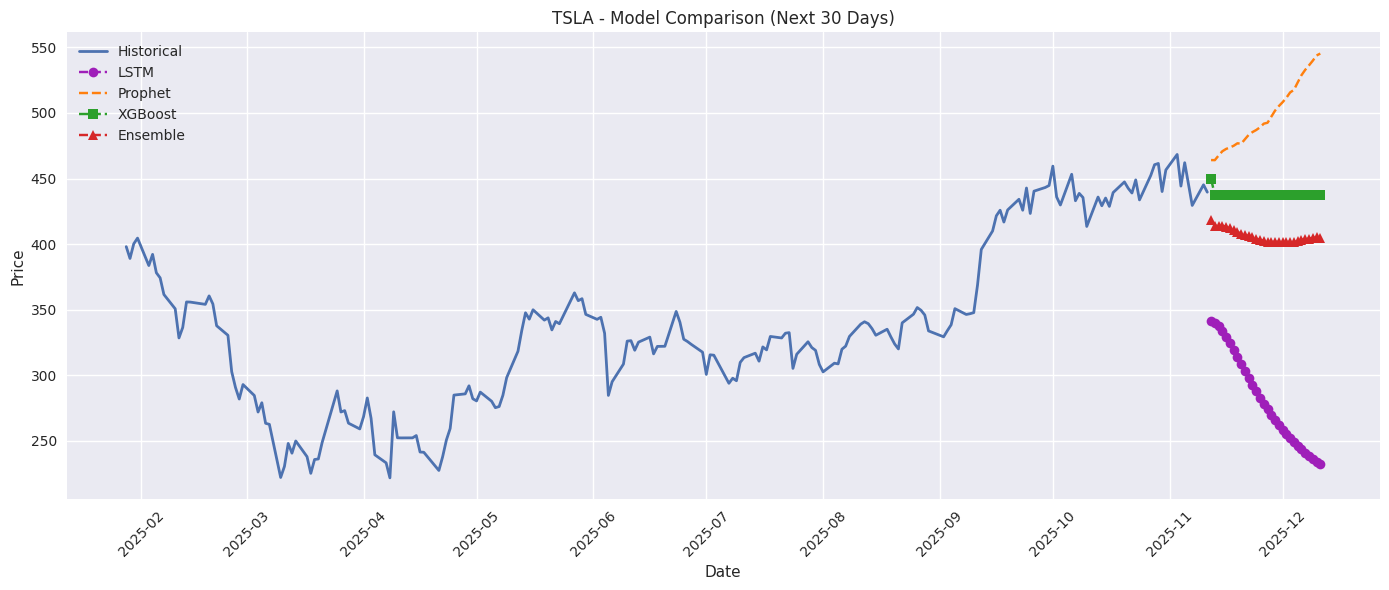

In [ ]:
# Graph I: LSTM, Prophet, XGBoost 30 days
future_dates_plot = comparison_df["Date"].iloc[:HORIZON]

plt.figure(figsize=(14,6))
colors = ["#9f1fb9", '#ff7f0e', '#2ca02c', '#d62728']  

# Plot históricos
plt.plot(df_full.index[-historical_days:], df_full[f'{ticker}_Close'].iloc[-historical_days:], 
         label="Historical", linewidth=2, color='#4d72b0')

# Plot future predictions (30 days)
plt.plot(future_dates_plot, comparison_df["LSTM_Price"].iloc[:HORIZON], marker='o', linestyle='--', color=colors[0], label="LSTM")
plt.plot(future_dates_plot, comparison_df["Prophet_Price"].iloc[:HORIZON], marker='x', linestyle='--', color=colors[1], label="Prophet")
plt.plot(future_dates_plot, comparison_df["XGB_Price"].iloc[:HORIZON], marker='s', linestyle='--', color=colors[2], label="XGBoost")
plt.plot(future_dates_plot, comparison_df["Ensemble_Price"].iloc[:HORIZON], marker='^', linestyle='--', color=colors[3], label="Ensemble")

plt.title(f"{ticker} - Model Comparison (Next {HORIZON} Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


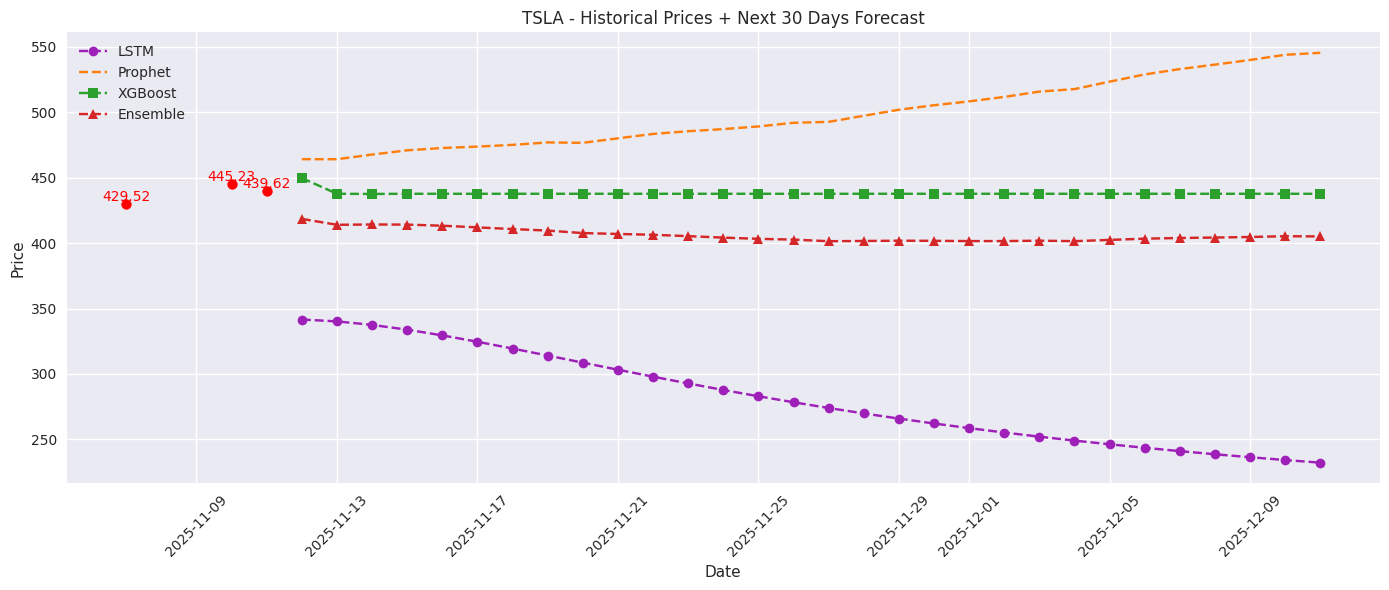

In [ ]:
# Graph II: LSTM, Prophet, XGBoost
colors = ["#9f1fb9", '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(14,6))

# -----------------------------
# Last 3 historical prices
# -----------------------------
last_prices = df_full[f'{ticker}_Close'].iloc[-3:]
last_dates = df_full.index[-3:]
plt.scatter(last_dates, last_prices, color='red', s=50, zorder=5)
for d, p in zip(last_dates, last_prices):
    plt.text(d, p, f"{p:.2f}", fontsize=10, ha='center', va='bottom', color="red")

# -----------------------------
# Future dates (next 30 days)
# -----------------------------
future_dates_plot = comparison_df["Date"].iloc[:HORIZON]

# -----------------------------
# Predictions (next 30 days)
# -----------------------------
if "LSTM_Price" in comparison_df.columns:
    plt.plot(future_dates_plot, comparison_df["LSTM_Price"].iloc[:HORIZON], marker='o', linestyle='--', 
             color=colors[0], label="LSTM")
if "Prophet_Price" in comparison_df.columns:
    plt.plot(future_dates_plot, comparison_df["Prophet_Price"].iloc[:HORIZON], marker='x', linestyle='--', 
             color=colors[1], label="Prophet")
if "XGB_Price" in comparison_df.columns:
    plt.plot(future_dates_plot, comparison_df["XGB_Price"].iloc[:HORIZON], marker='s', linestyle='--', 
             color=colors[2], label="XGBoost")
if "Ensemble_Price" in comparison_df.columns:
    plt.plot(future_dates_plot, comparison_df["Ensemble_Price"].iloc[:HORIZON], marker='^', linestyle='--', 
             color=colors[3], label="Ensemble")

# -----------------------------
# Titles and layout
# -----------------------------
plt.title(f"{ticker} - Historical Prices + Next {HORIZON} Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## ✅ Forecasting Methodologies Comparison (I–V)

**Overview**  
This module generates predictions for five types of forecasting approaches (I–V), each designed for specific objectives, data treatments, and trading strategies. It includes **trend determination, volatility-based ranges, and alerts** to aid decision-making.


### Forecast I – Percentage Returns

**Key Characteristics**  
- Predicts **next price based on percentage returns** rather than absolute price.  
- Uses **MinMaxScaler (-1,1)** for return normalization.  
- Multivariate sequences are supported, allowing other features to inform predictions.  
- Calculates a **volatility-based price range** for risk assessment.  
- Trend is determined based on percentage change.  
- Alerts include **high (>75%)**, **low (<25%)**, or **average levels** relative to historical distribution.  

**Ideal Use Case:** Traders focused on **risk/return analysis** and monitoring short-term momentum.  


### Forecast II – Absolute Price (Scaled)

**Key Characteristics**  
- Predicts **absolute next price** with scaling to (0,1).  
- Supports univariate and multivariate sequences.  
- Imposes a **limit of ±5% variation** from current price for stability.  
- Generates volatility-based price ranges for confidence intervals.  
- Trend detection and percentile alerts provide guidance for decision-making.  

**Ideal Use Case:** Analysts and traders seeking **stable price predictions** while keeping short-term variations under control.  


### Forecast III – Stable Multivariate

**Key Characteristics**  
- Works with **absolute price**, limiting variation to ±5%.  
- Focuses on **trend consistency** and organized code structure to avoid large swings.  
- Generates alerts based on **percentile thresholds** and **significant change (>3%)**.  
- Prioritizes **price stability**, suitable for **conservative strategies**.  

**Ideal Use Case:** Risk-averse traders requiring **stable signals with minimal noise**.  


### Forecast IV – Future Price Multivariate/Univariate + Multifeature Scaling

**Key Characteristics**  
- Predicts **absolute next price** while optionally preserving multiple features (multivariate).  
- Applies **scaling appropriate to context** (`scaler_uni` for univariate, multifeature for multivariate).  
- No explicit variation limit; scaling ensures coherent predictions.  
- Detects trend and generates percentile-based alerts.  
- Designed for **complex models** and future price forecasting with multiple inputs.  

**Ideal Use Case:** Technical analysts and modelers needing **precise multifeature forecasts**.  


### Forecast V – Percentage Returns with Volatility Range

**Key Characteristics**  
- Similar to **Forecast I** but emphasizes **volatility-based ranges** for predicted price.  
- Generates **upper and lower bounds** using recent historical volatility.  
- Trend detection and alerts mirror Forecast I.  
- Focuses on **risk-aware projections** with quantified uncertainty.  

**Ideal Use Case:** Traders and risk managers who want **return-based forecasts with confidence intervals**.  


### Summary Comparison

| Feature                        | Forecast I           | Forecast II        | Forecast III       | Forecast IV            | Forecast V           |
|:-------------------------------|:------------------:|:-----------------:|:-----------------:|:--------------------:|:------------------:|
| Prediction base                 | Percentage returns  | Absolute prices   | Absolute prices   | Multifeature prices   | Percentage returns |
| Scaler used                     | Returns (-1,1)      | Price (0-1)       | Price (0-1)       | Multifeature / Univariate | Returns (-1,1)  |
| Multivariate / Univariate       | Yes / No            | Yes / No          | Yes / No          | Yes / No              | Yes / No           |
| Variation limit                 | ±5%                 | ±5%               | ±5%               | Not explicit          | ±5%                |
| Automatic alerts                | ✅                  | ✅                | ✅                | ✅                    | ✅                 |
| Historical volatility           | ✅                  | ❌                | ❌                | ❌                    | ✅                 |
| Preservation of other features  | ❌                  | ❌                | ❌                | ✅                    | ❌                 |
| Trend determination             | ✅                  | ✅                | ✅                | ✅                    | ✅                 |
| Main focus                      | Risk / return (%)   | Stable price      | Stable price      | Future price multifeature | Risk / return w/range |

**Observations**  
- Forecast I and V: Best for **return-oriented strategies** with risk assessment.  
- Forecast II and III: Focus on **stable price predictions**, with III being more organized and conservative.  
- Forecast IV: Most robust for **multivariate and technical forecasting**, preserving additional features for precise modeling.  

**Usage Recommendations**  
- **Risk-averse traders:** Forecast III  
- **Return-oriented traders:** Forecast I or V  
- **Technical analysts:** Forecast IV  
- **General purpose / stable price:** Forecast II


In [ ]:
# ===============================================
# 🔹 DEFINE COLUMNS DYNAMICALLY
# ===============================================
price_col = f"{ticker}_Close"
volume_col = f"{ticker}_Volume"

In [ ]:
# ===============================================
# 🔹 GENERIC PREDICTION FUNCTION WITH RANGES
# ===============================================
def predict_price_with_range(df, model, ticker, scaled_data, SEQ_LEN=20,
                             USE_MULTIVARIATE=True, mode='I', scaler_uni=None,
                             limit_change_pct=0.05, vol_window=20):
    """
    Function to generate predictions type I, II, III, IV or V with volatility-based range.
    """
    price_col = f"{ticker}_Close"
    
    # -------------------------
    # Prediction
    # -------------------------
    if mode == 'I' or mode == 'V':  # Percentage returns
        df['Returns'] = df[price_col].pct_change().fillna(0)
        scaler_returns = MinMaxScaler(feature_range=(-1,1))
        scaled_returns = scaler_returns.fit_transform(df[['Returns']].values)
        
        if USE_MULTIVARIATE:
            last_seq = scaled_data[-SEQ_LEN:].copy()
            last_seq[:,0] = scaled_returns[-SEQ_LEN:,0].flatten()
            last_seq_exp = last_seq[np.newaxis,:,:]
        else:
            last_seq_exp = scaled_returns[-SEQ_LEN:].reshape(1,SEQ_LEN,1)
        
        next_scaled_return = model.predict(last_seq_exp)[0,0]
        next_return = scaler_returns.inverse_transform([[next_scaled_return]])[0,0]
        current_price = df[price_col].iloc[-1]
        next_price = current_price * (1 + next_return)
        
    else:  # Absolute price (II, III, IV)
        scaler_price = scaler_uni if scaler_uni else MinMaxScaler()
        if not scaler_uni:
            scaler_price.fit(df[[price_col]])
        
        if USE_MULTIVARIATE:
            last_seq = scaled_data[-SEQ_LEN:].copy()
            if mode in ['II','III']:
                last_seq[:,0] = scaler_price.transform(last_seq[:,0].reshape(-1,1)).flatten()
            last_seq_exp = last_seq[np.newaxis,:,:]
            next_scaled = model.predict(last_seq_exp)[0,0]
            
            if mode == 'IV':
                next_scaled_2d = np.array([[next_scaled]])
                other_features_last = last_seq[-1,1:].reshape(1,-1)
                next_price = scaler_price.inverse_transform(np.hstack([next_scaled_2d, other_features_last]))[0,0]
            else:
                next_price = scaler_price.inverse_transform([[next_scaled]])[0,0]
        else:
            last_seq_uni = scaled_data[-SEQ_LEN:,0].reshape(-1,1)
            last_seq_exp = last_seq_uni[np.newaxis,:,:]
            next_scaled = model.predict(last_seq_exp)[0,0]
            next_price = scaler_price.inverse_transform([[next_scaled]])[0,0]
        
        current_price = df[price_col].iloc[-1]
        if mode in ['II','III']:
            next_price = max(min(next_price, current_price*(1+limit_change_pct)),
                             current_price*(1-limit_change_pct))
    
    # -------------------------
    # Comparison with current price
    # -------------------------
    change = next_price - current_price
    change_pct = (change / current_price) * 100
    
    # -------------------------
    # Trend
    # -------------------------
    if change_pct > 1:
        trend = "📈 STRONG UPTREND"
    elif change_pct > 0:
        trend = "↗️ UPTREND"
    elif change_pct < -1:
        trend = "📉 STRONG DOWNTREND"
    else:
        trend = "↘️ DOWNTREND"
    
    # -------------------------
    # Price range based on volatility
    # -------------------------
    df['Returns'] = df[price_col].pct_change()
    vol_recent = df['Returns'].iloc[-vol_window:].std()
    price_lower = current_price * (1 + (next_return if mode in ['I','V'] else (next_price-current_price)/current_price) - vol_recent)
    price_upper = current_price * (1 + (next_return if mode in ['I','V'] else (next_price-current_price)/current_price) + vol_recent)
    change_lower_pct = (price_lower - current_price) / current_price * 100
    change_upper_pct = (price_upper - current_price) / current_price * 100
    
    # -------------------------
    # Alert system
    # -------------------------
    HIGH_PRICE_THRESHOLD = df[price_col].quantile(0.75)
    LOW_PRICE_THRESHOLD = df[price_col].quantile(0.25)
    alerts = []
    
    if next_price > HIGH_PRICE_THRESHOLD:
        alerts.append("⚠️ Pred price HIGH (>75% hist)")
    elif next_price < LOW_PRICE_THRESHOLD:
        alerts.append("✅ Pred price LOW (<25% hist)")
    else:
        alerts.append("📊 Pred price at AVERAGE levels")
    
    return {
        "current_price": current_price,
        "next_price": next_price,
        "change": change,
        "change_pct": change_pct,
        "trend": trend,
        "alerts": alerts,
        "price_lower": price_lower,
        "price_upper": price_upper,
        "change_lower_pct": change_lower_pct,
        "change_upper_pct": change_upper_pct
    }

# ===============================================
# 🔹 GENERATE ALL PREDICTIONS (I–V)
# ===============================================
modes = ['I','II','III','IV','V']
results = {}

for mode in modes:
    results[mode] = predict_price_with_range(df=df_full, model=lstm_model, ticker=ticker,
                                             scaled_data=scaled_data, SEQ_LEN=SEQ_LEN,
                                             USE_MULTIVARIATE=True, mode=mode)

# ===============================================
# 🔹 CREATE TABLE WITH COLUMNS = PREDICTIONS
# ===============================================
table_dict = {}

for mode, res in results.items():
    table_dict[mode] = {
        "Current Price": res['current_price'],
        "Predicted Price": res['next_price'],
        "Change ($)": res['change'],
        "Change (%)": res['change_pct'],
        "Trend": res['trend'],
        "Lower Price": res['price_lower'],
        "Upper Price": res['price_upper'],
        "Lower Change (%)": res['change_lower_pct'],
        "Upper Change (%)": res['change_upper_pct'],
        "Alerts": " | ".join(res['alerts'])
    }

df_table = pd.DataFrame(table_dict)

# Format numeric values to 2 decimal places
numeric_rows = ["Current Price","Predicted Price","Change ($)","Change (%)",
                "Lower Price","Upper Price","Lower Change (%)","Upper Change (%)"]
for row in numeric_rows:
    df_table.loc[row] = df_table.loc[row].apply(lambda x: round(x,2))

# Mostrar tabela
print("\n📊 Comparativo de Previsões I–V com Faixas e Alertas")
display(df_table)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📊 Comparativo de Previsões I–V com Faixas e Alertas


,I,II,III,IV,V
Current Price,439.62,439.62,439.62,439.62,439.62
Predicted Price,457.34,417.64,417.64,341.37,457.34
Change ($),17.72,-21.98,-21.98,-98.25,17.72
Change (%),4.03,-5.0,-5.0,-22.35,4.03
Trend,📈 STRONG UPTREND,📉 STRONG DOWNTREND,📉 STRONG DOWNTREND,📉 STRONG DOWNTREND,📈 STRONG UPTREND
Lower Price,443.85,404.15,404.15,327.87,443.85
Upper Price,470.83,431.13,431.13,354.86,470.83
Lower Change (%),0.96,-8.07,-8.07,-25.42,0.96
Upper Change (%),7.1,-1.93,-1.93,-19.28,7.1
Alerts,⚠️ Pred price HIGH (>75% hist),⚠️ Pred price HIGH (>75% hist),⚠️ Pred price HIGH (>75% hist),⚠️ Pred price HIGH (>75% hist),⚠️ Pred price HIGH (>75% hist)


## ✅ Detailed Future Prediction (First N Days)

**Overview**  
Generates multi-day price forecasts with volatility-based ranges, trend analysis, and percentage changes. Includes the current price as a baseline for comparison.

**Key Features**  
Predicts future prices step-by-step using the LSTM model, calculates daily percentage changes, classifies trends with visual indicators, and references historical percentile thresholds.

**Important Details**  
Uses 20-day recent volatility for range calculations, maintains sequence consistency for recursive predictions, includes the current price, and formats results professionally with rounded values.

**Output Components**  
Future price predictions, daily percentage changes, trend direction (strong uptrend, uptrend, downtrend, strong downtrend), volatility-based price ranges, and current price baseline.

**Technical Implementation**  
Recursive sequence updating for multi-step forecasting, inverse scaling for price conversion, volatility calculation from recent returns, and sequential percentage change computation.


In [ ]:
# ===============================================
# 🔟 DETAILED FUTURE PREDICTION (First 10 days)
# ===============================================
future_predictions = []
last_sequence = scaled_data[-SEQ_LEN:].copy()

# Calculate recent volatility for ranges
df_full['Returns'] = df_full[price_col].pct_change()
vol_recent = df_full['Returns'].iloc[-20:].std()  # Last 20 trading days

# Historical limits
HIGH_PRICE_THRESHOLD = df_full[price_col].quantile(0.75)
LOW_PRICE_THRESHOLD = df_full[price_col].quantile(0.25)

for _ in range(FUTURE_DAYS):
    # Scaled prediction
    pred_scaled = lstm_model.predict(last_sequence[np.newaxis, :, :])[0,0]
    future_predictions.append(pred_scaled)
    
    # Update sequence with prediction
    new_row = np.hstack([[pred_scaled], last_sequence[-1, 1:]])
    last_sequence = np.vstack([last_sequence[1:], new_row])

# Transform back to real price
future_prices = scaler.inverse_transform(
    np.hstack([np.array(future_predictions).reshape(-1,1),
               np.tile(last_sequence[-1,1:], (FUTURE_DAYS,1))])
)[:,0]

# Create future dates
future_dates = pd.date_range(df_full.index[-1] + pd.Timedelta(days=1), periods=FUTURE_DAYS)

# Create DataFrame
future_df = pd.DataFrame({"Future_Price": future_prices}, index=future_dates)

# Previous price for daily variation calculation
prev_price = df_full[price_col].iloc[-1]

# Calculate percentage change, trends, ranges and alertss
pct_changes = []
tendencies = []
price_lower = []
price_upper = []
alerts = []

for price in future_df["Future_Price"]:
    # Percentage change
    pct_change = (price - prev_price) / prev_price * 100
    pct_changes.append(pct_change)
    
    # Trend
    if pct_change > 1:
        trend = "📈 STRONG UPTREND"
    elif pct_change > 0:
        trend = "↗️ UPTREND"
    elif pct_change < -1:
        trend = "📉 STRONG DOWNTREND"
    else:
        trend = "↘️ DOWNTREND"
    tendencies.append(trend)
    
    # Faixa de preço
    lower = price - vol_recent * prev_price
    upper = price + vol_recent * prev_price
    price_lower.append(lower)
    price_upper.append(upper)
    prev_price = price

# Add columns to DataFrame
future_df["Pct_Change (%)"] = pct_changes
future_df["Trend"] = tendencies
future_df["Lower Price"] = price_lower
future_df["Upper Price"] = price_upper

# Add current price row
current_price = df_full[price_col].iloc[-1]
prev_price = df_full[price_col].iloc[-2]
current_pct_change = (current_price - prev_price)/prev_price * 100

current_row = pd.DataFrame({
    "Future_Price": [current_price],
    "Pct_Change (%)": [current_pct_change],
    "Upper Price": [current_price + vol_recent*current_price],
    "Lower Price": [current_price - vol_recent*current_price],
    "Trend": ["↗️ Current"]
    #"Alerts": [""]
}, index=[df_full.index[-1]])

future_df = pd.concat([current_row, future_df])
future_df = future_df.round(2)

# Show table
print("\n📊 Detailed forecast for the coming days")
display(future_df.head(10))  # Shows first 10 days

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

,Future_Price,Pct_Change (%),Upper Price,Lower Price,Trend
2025-11-11,439.62,-1.26,453.11,426.13,↗️ Current
2025-11-12,341.37,-22.35,354.86,327.87,📉 STRONG DOWNTREND
2025-11-13,339.39,-0.58,349.86,328.91,↘️ DOWNTREND
2025-11-14,336.13,-0.96,346.54,325.71,↘️ DOWNTREND
2025-11-15,331.91,-1.26,342.22,321.59,📉 STRONG DOWNTREND
2025-11-16,326.99,-1.48,337.18,316.81,📉 STRONG DOWNTREND
2025-11-17,321.60,-1.65,331.63,311.56,📉 STRONG DOWNTREND
2025-11-18,315.91,-1.77,325.78,306.04,📉 STRONG DOWNTREND
2025-11-19,310.07,-1.85,319.76,300.37,📉 STRONG DOWNTREND
2025-11-20,304.19,-1.90,313.70,294.67,📉 STRONG DOWNTREND


## ✅ Future Prediction Visualization

**Overview**  
Creates a clear visualization showing historical price trends alongside future predictions with confidence intervals, providing an intuitive view of forecasted movements.

**Key Features**  
Displays the last 365 days of historical prices, future predictions with markers, confidence intervals, professional formatting with grids and legend, and a clear distinction between historical and forecasted data.

**Important Details**  
Applies proper inverse scaling for historical data, connects future predictions with markers, displays shaded confidence intervals for price ranges, and maintains consistent colors for clarity. Provides both historical context and future outlook.

**Visual Elements**  
- Blue line: Historical price trend  
- Green line with circles: Future price predictions  
- Green shaded area: Predicted price range (confidence interval)  
- Grid and legend for clear interpretation  

**Use Cases**  
Supports technical analysis, trend identification, risk assessment with price ranges, investment decision-making, and model performance evaluation.


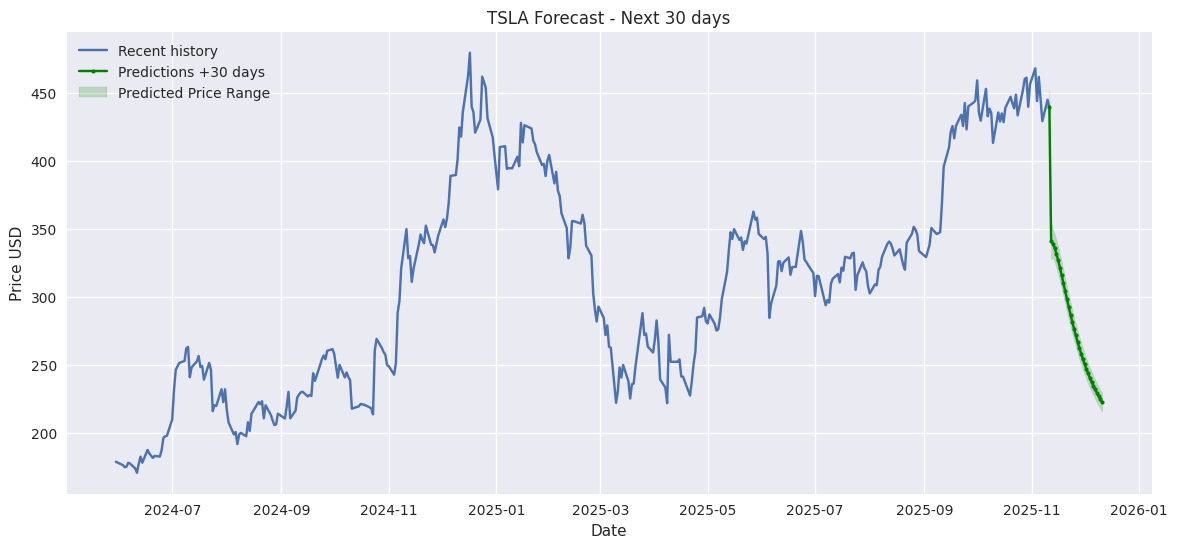

In [ ]:
plt.figure(figsize=(14,6))

# Recent history (last 365 days)
hist_prices = scaler.inverse_transform(scaled_data[-365:,:])[:,0]
plt.plot(df_full.index[-365:], hist_prices, label="Recent history", color='#4d72b0')

# Future predictions
plt.plot(future_df.index, future_df["Future_Price"], marker="o", linestyle="-",
         markersize=3, label=f"Predictions +{FUTURE_DAYS} days", color="green")

# Lower and Upper Price Zone
plt.fill_between(future_df.index,
                 future_df["Lower Price"],
                 future_df["Upper Price"],
                 color="green", alpha=0.2, label="Predicted Price Range")

plt.title(f"{ticker} Forecast - Next {FUTURE_DAYS} days")
plt.xlabel("Date")
plt.ylabel("Price USD")
plt.legend()
plt.grid(True)
plt.show()


## ✅ Monte Carlo Risk Analysis with Confidence Intervals

**Overview**  
Performs Monte Carlo simulation for price forecasting with risk analysis, including VaR, CVaR, and Sharpe ratio calculations.

**Key Features**  
Generates 500 simulated price paths using log-returns, calculates confidence intervals (5th-95th percentiles), computes risk metrics, and provides visual analysis of price distribution.

**Important Details**  
Uses 20-day recent volatility for simulations, incorporates forecasted log-returns as baseline, adds random noise based on historical volatility, and provides both point estimates and confidence ranges with professional formatting.

**Risk Metrics**  
- VaR 95%: Maximum expected loss at 95% confidence  
- CVaR 95%: Expected loss in worst 5% scenarios  
- Sharpe Ratio: Annualized risk-adjusted return  
- Confidence Intervals: 5th-95th percentile price ranges  

**Visual Components**  
Monte Carlo paths with mean and confidence bands, historical price markers for context, final price distribution histogram, and current price reference line.


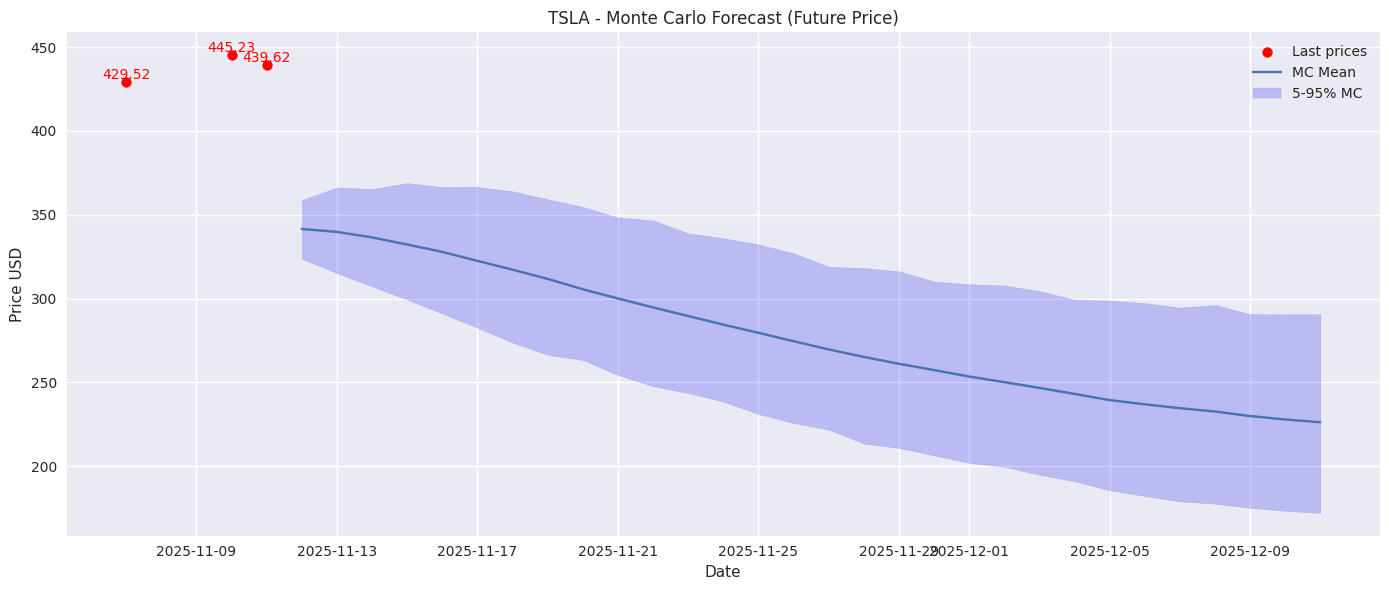


🔍 RISK ANALYSIS - CONFIDENCE INTERVALS & RISK METRICS
Avg 5-95% Range Width: $96.49
📉 Value at Risk (VaR 95%): -60.86%
⚠️ Conditional VaR (CVaR 95%): -64.01%
📈 Sharpe Ratio (Annualized): -94.82
📉 Monte Carlo simulation is conservative compared to current price


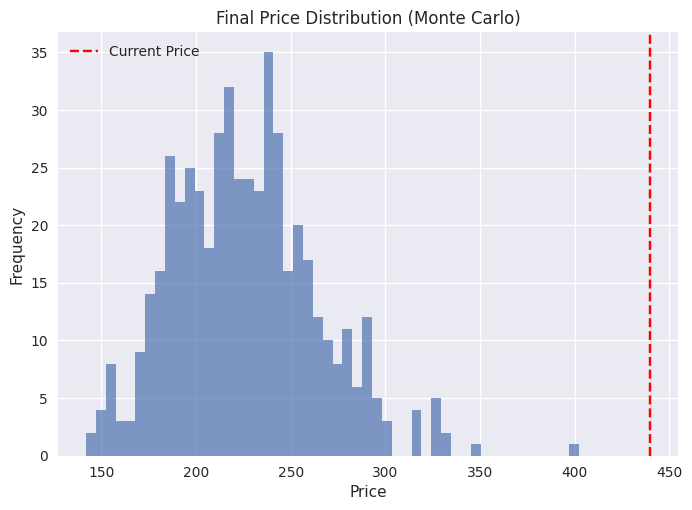

In [ ]:
# -----------------------------
# Settings
# -----------------------------
np.random.seed(42)
N_SIM = 500
HORIZON_MC = len(future_df)-1
S0 = float(future_df["Future_Price"].iloc[0])

# -----------------------------
# Calculate log-returns from forecast
# -----------------------------
def logrets_from_prices(prices, S0):
    lr = np.zeros(len(prices))
    for t in range(len(prices)):
        lr[t] = np.log(prices[t] / (S0 if t==0 else prices[t-1]))
    return lr

future_prices_array = future_df["Future_Price"].iloc[1:].values
pred_logrets = logrets_from_prices(future_prices_array, S0)

# -----------------------------
# Monte Carlo Simulation
# -----------------------------
df_full['Returns'] = df_full[price_col].pct_change()
vol_recent = df_full['Returns'].iloc[-20:].std()

def monte_carlo_paths(pred_logrets, S0, N_SIM, vol_daily):
    paths = np.zeros((len(pred_logrets), N_SIM))
    for i in range(N_SIM):
        price = S0
        for t in range(len(pred_logrets)):
            lr = pred_logrets[t] + np.random.normal(0, vol_daily)
            price *= np.exp(lr)
            paths[t, i] = price
    return paths

mc_paths = monte_carlo_paths(pred_logrets, S0, N_SIM, vol_recent)

# -----------------------------
# Statistics: mean + 5-95%
# -----------------------------
mc_mean = mc_paths.mean(axis=1)
mc_5 = np.percentile(mc_paths, 5, axis=1)
mc_95 = np.percentile(mc_paths, 95, axis=1)

# -----------------------------
# Plot Monte Carlo
# -----------------------------
plt.figure(figsize=(14,6))
last_prices = df_full[price_col].iloc[-3:]
last_dates = df_full.index[-3:]
plt.scatter(last_dates, last_prices, color='red', s=50, label="Last prices")
for d, p in zip(last_dates, last_prices):
    plt.text(d, p, f"{p:.2f}", fontsize=10, ha='center', va='bottom', color='red')

future_dates_plot = future_df.index[1:]
plt.plot(future_dates_plot, mc_mean, color='#4d72b0', linestyle='-', label="MC Mean")
plt.fill_between(future_dates_plot, mc_5, mc_95, color='blue', alpha=0.2, label="5-95% MC")

plt.title(f"{ticker} - Monte Carlo Forecast (Future Price)")
plt.xlabel("Date")
plt.ylabel("Price USD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Risk Analysis
# -----------------------------
def compute_risk_metrics(paths, S0):
    final_prices = paths[-1]
    returns = (final_prices / S0) - 1
    var_95 = np.percentile(returns, 5)
    cvar_95 = returns[returns <= var_95].mean()
    risk_free_rate = 0.03
    sharpe = ((returns.mean() - risk_free_rate) / returns.std()) * np.sqrt(252)
    return var_95, cvar_95, sharpe

mc_var, mc_cvar, mc_sharpe = compute_risk_metrics(mc_paths, S0)
avg_range_width = np.mean(mc_95 - mc_5)

print("\n🔍 RISK ANALYSIS - CONFIDENCE INTERVALS & RISK METRICS")
print("="*60)
print(f"Avg 5-95% Range Width: ${avg_range_width:.2f}")
print(f"📉 Value at Risk (VaR 95%): {mc_var:.2%}")
print(f"⚠️ Conditional VaR (CVaR 95%): {mc_cvar:.2%}")
print(f"📈 Sharpe Ratio (Annualized): {mc_sharpe:.2f}")

# Optimism/conservatism comparing last average price vs initial
if mc_mean[-1] > S0:
    print(f"📈 Monte Carlo simulation is optimistic compared to current price")
else:
    print(f"📉 Monte Carlo simulation is conservative compared to current price")

plt.hist(mc_paths[-1,:], bins=50, alpha=0.7, color='#4d72b0')
plt.axvline(S0, color='red', linestyle='--', label='Current Price')
plt.title("Final Price Distribution (Monte Carlo)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## ✅ Historical Volatility Calculation (Dynamic)

**Overview**  
Calculates dynamic historical volatility using log returns and prepares sequences for time series forecasting with models like LSTM.

**Key Features**  
Computes log returns for any ticker, estimates rolling 10-day volatility, creates sequences for forecasting, applies train-test split, and normalizes volatility with Min-Max scaling.

**Important Details**  
Uses a 10-day rolling window, handles NaN values from initial calculations, creates 30-day sequences while maintaining temporal order, and prepares data for time series models.

**Technical Implementation**  
- Log returns: ln(P_t / P_t-1)  
- Volatility: Standard deviation of log returns  
- Sequence length: 30 days for historical context  
- Train-test split: 80-20% for model training  

**Use Cases**  
Supports volatility forecasting, risk assessment, option pricing, and portfolio optimization.


In [ ]:
# ===============================================
# 2️⃣ HISTORICAL VOLATILITY CALCULATION (Dynamic)
# ===============================================
target_col = f"{ticker}_Close"  # Dynamic price

df_full['Log_Returns'] = np.log(df_full[target_col] / df_full[target_col].shift(1))
df_full['Volatility'] = df_full['Log_Returns'].rolling(10).std()

# Remove initial NaN values
df_vol = df_full.dropna(subset=['Volatility'])

# Volatility normalization
vol_scaler = MinMaxScaler()
vol_scaled = vol_scaler.fit_transform(df_vol['Volatility'].values.reshape(-1,1))

SEQ_LEN_VOL = 30  # 30-day sequence for volatility prediction

def create_sequences_vol(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i][0])  # Volatility value
    return np.array(X), np.array(y)

X_vol, y_vol = create_sequences_vol(vol_scaled, SEQ_LEN_VOL)

train_size_vol = int(0.8 * len(X_vol))
X_train_vol, X_test_vol = X_vol[:train_size_vol], X_vol[train_size_vol:]
y_train_vol, y_test_vol = y_vol[:train_size_vol], y_vol[train_size_vol:]

### 2️⃣ LSTM Model for Volatility Forecasting

**Overview**  
Implements a specialized LSTM neural network for volatility time series forecasting, using dropout regularization and early stopping to optimize performance.

**Key Features**  
Two-layer LSTM with dropout, early stopping to prevent overfitting, MSE loss function, Adam optimizer, and validation split for model evaluation.

**Model Architecture**  
- Input: (30, 1) volatility sequences  
- First LSTM layer: 50 units, return sequences  
- Dropout: 20%  
- Second LSTM layer: 30 units  
- Dropout: 20%  
- Output: Dense layer with 1 unit (volatility prediction)  

**Training Configuration**  
- Optimizer: Adam  
- Loss: Mean Squared Error (MSE)  
- Batch size: 16  
- Epochs: 50 (with early stopping)  
- Validation split: 10%  
- Early stopping patience: 10 epochs  

**Use Cases**  
Supports financial volatility prediction, risk management systems, option pricing, and portfolio risk assessment.


In [ ]:
# ===============================================
# 3️⃣ LSTM MODEL FOR VOLATILITY
# ===============================================
model_vol = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN_VOL,1)),
    Dropout(0.2),
    LSTM(30),
    Dropout(0.2),
    Dense(1)
])
model_vol.compile(optimizer='adam', loss='mse')
model_vol.summary()

es_vol = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_vol = model_vol.fit(
    X_train_vol, y_train_vol,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[es_vol],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,151 (78.71 KB)

 Trainable params: 20,151 (78.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0293 - val_loss: 0.0617
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0182 - val_loss: 0.0613
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0155 - val_loss: 0.0542
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0147 - val_loss: 0.0572
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0130 - val_loss: 0.0434
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0114 - val_loss: 0.0431
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0108 - val_loss: 0.0344
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0109 - val_loss: 0.0357
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0103 - val_loss: 0.0258
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0097 - val_loss: 0.0194
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0092 - val_loss: 0.0216
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

### 3️⃣ Future Volatility Prediction (30 Days)

**Overview**  
Generates 30-day volatility forecasts using the trained LSTM model, providing insights for risk management and trading strategy planning.

**Key Features**  
Performs iterative 30-day forecasting with recursive sequence updates, applies proper inverse scaling, aligns predictions with future dates, and formats output for easy interpretation.

**Important Details**  
Starts from the last 30 days of volatility data, iteratively updates sequences, maintains proper scaling, aligns predictions with corresponding dates, and provides volatility in original units (standard deviation).

**Technical Implementation**  
- Sequence length: 30 days  
- Iterative prediction with sequence rolling  
- MinMax scaling and inverse transformation  
- Date range generation for future periods  

**Use Cases**  
Supports risk management, option strategy planning, portfolio volatility forecasting, and market regime detection.


In [ ]:
# ===============================================
# 4️⃣ FUTURE VOLATILITY PREDICTION (30 DAYS)
# ===============================================
SEQ_LEN_VOL = 30  # sequence length used in volatility model

# Scale volatility
vol_scaled = MinMaxScaler().fit_transform(df_vol['Volatility'].values.reshape(-1,1))

future_vol_predictions = []
last_seq_vol = vol_scaled[-SEQ_LEN_VOL:].copy()

# Iterative prediction for next 30 days
for _ in range(30):
    pred_vol_scaled = model_vol.predict(last_seq_vol[np.newaxis, :, :])[0]
    future_vol_predictions.append(pred_vol_scaled[0])
    # Update sequence
    last_seq_vol = np.vstack([last_seq_vol[1:], [[pred_vol_scaled[0]]]])

# Denormalize predictions
scaler_vol = MinMaxScaler().fit(df_vol['Volatility'].values.reshape(-1,1))
future_vol = scaler_vol.inverse_transform(np.array(future_vol_predictions).reshape(-1,1))[:,0]

# Future dates
future_vol_dates = pd.date_range(df_vol.index[-1] + pd.Timedelta(days=1), periods=30)
future_vol_df = pd.DataFrame({"Future_Volatility": future_vol}, index=future_vol_dates)

print("\n📌 Volatility forecast for the next 30 days:")
print(future_vol_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

### 4️⃣ Integrated Volatility Alert System (30-Day Forecast)

**Overview**  
Provides a 30-day volatility forecasting system with multi-level alerts, statistical summaries, and visualizations for informed risk management and trading decisions.

**Key Features**  
Analyzes 30-day volatility forecasts, implements multi-level alerts based on percentiles, summarizes statistics (current, max, min, average volatility), detects significant changes (>15%), and offers professional visualizations with historical context.

**Alert System**  
- High Volatility Alert: >75th percentile – triggers protection strategies  
- Low Volatility Alert: <25th percentile – favorable for directional trading  
- Medium Volatility: Normal market conditions  
- Significant Change Alert: >15% average volatility shift  

**Statistical Metrics**  
Current volatility baseline, predicted max/min volatility, 30-day average forecast, and percentage changes from current levels.

**Visualization**  
Shows 60-day historical volatility trends, 30-day predicted forecasts, current volatility reference line, with professional formatting including grids and legend.



📈 VOLATILITY MODEL SUMMARY

🚨 VOLATILITY ALERT SYSTEM (Next 30 Days):
   📊 Predicted average volatility for next 30 days is at MEDIUM levels

📊 Volatility Forecast Summary (30 Days):
   Current Volatility : 0.037273 (3.7273%)
   Predicted Max      : 0.039882 (3.9882%)
   Predicted Min      : 0.037555 (3.7555%)
   Predicted Average  : 0.039017 (3.9017%)
✅ MODEL BUILT AND EVALUATED SUCCESSFULLY!


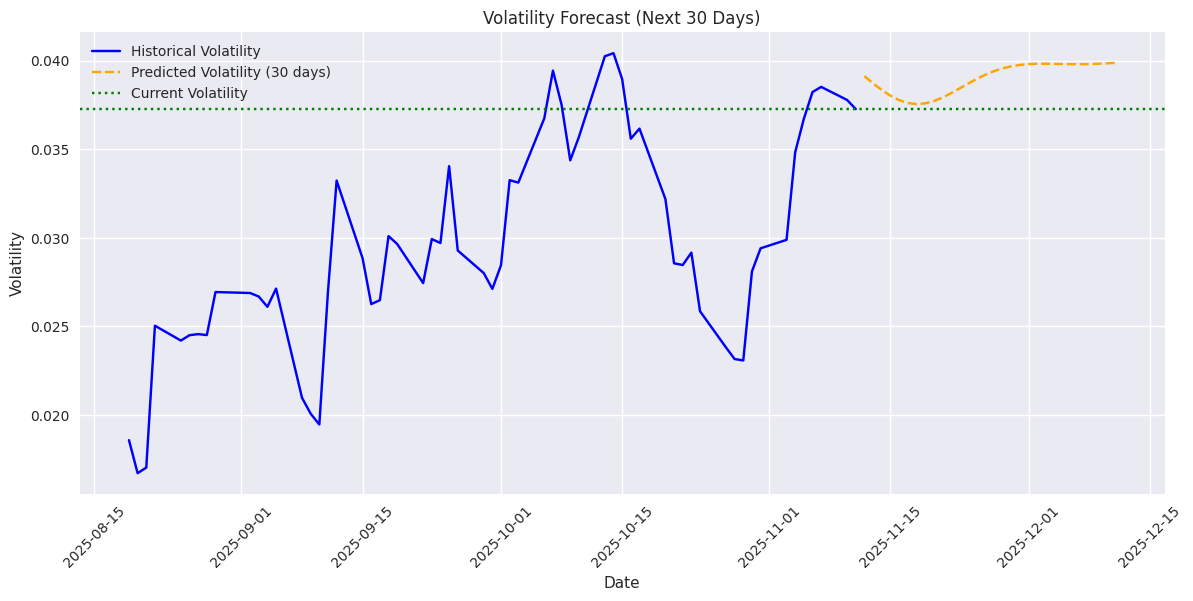

In [ ]:
# ===============================================
# 🔟 INTEGRATED ALERT SYSTEM (30-DAY FORECAST)
# ===============================================

print("\n" + "="*80)
print("📈 VOLATILITY MODEL SUMMARY")
print("="*80)
print(f"\n🚨 VOLATILITY ALERT SYSTEM (Next 30 Days):")

# Statistics for next 30 days
current_volatility = df_vol['Volatility'].iloc[-1]
future_max = future_vol.max()
future_min = future_vol.min()
future_mean = future_vol.mean()
future_change_pct = (future_mean - current_volatility) / current_volatility * 100

# Percentile thresholds
HIGH_VOL_THRESHOLD = df_vol['Volatility'].quantile(0.75)
LOW_VOL_THRESHOLD = df_vol['Volatility'].quantile(0.25)

# -----------------------------------------------
# Level Alerts based on average volatility
# -----------------------------------------------

if future_mean > HIGH_VOL_THRESHOLD:
    print(f"   ⚠️  ALERT: Predicted average volatility for next 30 days is HIGH (> 75th percentile)")
    print(f"   💡 Recommendation: Consider protection strategies")
elif future_mean < LOW_VOL_THRESHOLD:
    print(f"   ✅ Predicted average volatility for next 30 days is LOW (< 25th percentile)")
    print(f"   💡 Recommendation: Favorable environment for directional trades")
else:
    print(f"   📊 Predicted average volatility for next 30 days is at MEDIUM levels")

# -----------------------------------------------
# Significant change alerts
# -----------------------------------------------
if abs(future_change_pct) > 15:
    change_type = "increase" if future_change_pct > 0 else "decrease"
    print(f"   🔥 ALERT: Significant average volatility {change_type} over 30 days ({future_change_pct:+.1f}%)")

# -----------------------------------------------
# Summary of forecast
# -----------------------------------------------
print("\n📊 Volatility Forecast Summary (30 Days):")
print(f"   Current Volatility : {current_volatility:.6f} ({current_volatility*100:.4f}%)")
print(f"   Predicted Max      : {future_max:.6f} ({future_max*100:.4f}%)")
print(f"   Predicted Min      : {future_min:.6f} ({future_min*100:.4f}%)")
print(f"   Predicted Average  : {future_mean:.6f} ({future_mean*100:.4f}%)")

print(f"✅ MODEL BUILT AND EVALUATED SUCCESSFULLY!")

# ===============================================
# Plot Volatility Forecast
# ===============================================
plt.figure(figsize=(14,6))
plt.plot(df_vol.index[-60:], df_vol['Volatility'].iloc[-60:], label='Historical Volatility', color='blue')
plt.plot(future_vol_dates, future_vol, label='Predicted Volatility (30 days)', color='orange', linestyle='--')
plt.axhline(current_volatility, color='green', linestyle=':', label='Current Volatility')

plt.title('Volatility Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### 5️⃣ Future Volatility Visualization

**Overview**  
Creates a clear visualization comparing historical volatility trends with future forecasts, providing insights into expected market volatility patterns.

**Key Features**  
Displays the last 365 days of historical volatility, future predictions with markers, professional chart formatting with grids and legend, clear distinction between historical and forecasted data, and proper time-series alignment.

**Visual Elements**  
- Blue line: Historical volatility trend  
- Green line with circles: Future volatility predictions  
- Grid and legend for easy interpretation  
- Proper date formatting on the x-axis  

**Important Details**  
Uses the last 365 days for historical context, shows future predictions as connected points with markers, maintains consistent time scale, and provides volatility values in standard deviation units.

**Use Cases**  
Supports volatility trend analysis, risk assessment, trading strategy development, and market regime identification.


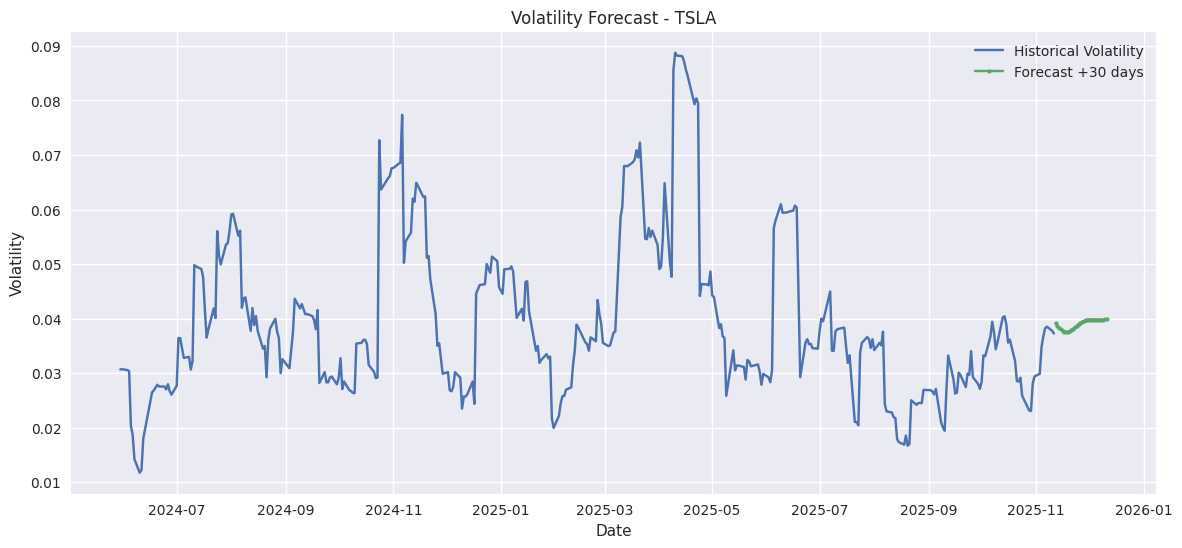

In [ ]:
# ===============================================
# 5️⃣ FUTURE VOLATILITY CHART
# ===============================================
plt.figure(figsize=(14,6))

# Historical volatility (last 365 days)
plt.plot(df_vol.index[-365:], df_vol['Volatility'][-365:], label="Historical Volatility")

# Future predictions
plt.plot(future_vol_df.index, future_vol_df['Future_Volatility'], marker='o', linestyle='-',markersize=3, label=f"Forecast +{FUTURE_DAYS} days")

plt.title(f"Volatility Forecast - {ticker}")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ===============================================
# 💾 SAVING TRAINED MODEL
# ===============================================
print("💾 Saving trained model...")

# Save the LSTM model
lstm_model.save("forecasting.keras")

print("✅ Model saved as 'forecasting.keras'")

# We will also save the scaler for future use
import joblib

# Save the scaler
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as 'scaler.pkl'")

# Save ticker information and settings
model_info = {
    "ticker": ticker,
    "seq_len": SEQ_LEN,
    "features": df_full.columns.tolist(),
    "target_col": target_col,
    "data_start": data_start
}

joblib.dump(model_info, "model_info.pkl")
print("✅ Model info saved as 'model_info.pkl'")

💾 Salvando modelo treinado...
✅ Modelo salvo como 'forecasting.keras'
✅ Scaler salvo como 'scaler.pkl'
✅ Informações do modelo salvas como 'model_info.pkl'
